In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn
from pandas.io.excel import ExcelWriter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing

In [2]:
elec_df = pd.read_excel("electronika_03_04_col.xlsx")
citylst = pd.read_excel("citylst.xlsx")

# Предобработка данных

Выбираем строки с известными номерами телефонов и ненулевой ценой товаров  
Изменение столбца месяца на числовой тип данных

In [3]:
elec_df = elec_df[(elec_df['RowSum']!=0)&(elec_df['Phone_new'] != 0)&(elec_df['TN'] != 'Услуги')]
elec_df['месяц'] = elec_df['месяц'].astype('int')

Заполнение недостающих значений категорий и подкатегорий в TN и TK


In [4]:
#Вывод незаполненных полей столбца TN
print(elec_df['NomGroup'].loc[elec_df['TN'].isna()].unique())
#Результат:
#Фен-щетки, Саундбары, Портативные колонки, Музыкальные центры, Кроватки-трансформеры, Кроватки с маятником, Коляски-люльки, Клавиатуры, Группа 0/0+ (до 13 кг), Apple iPad
uniqlst = ['Фен-щетки', 'Саундбары', 'Портативные колонки', 'Музыкальные центры', 'Кроватки-трансформеры', 'Кроватки с маятником', 'Коляски-люльки', 'Клавиатуры', 'Группа 0/0+ (до 13 кг)', 'Apple iPad'] 
print(uniqlst)
for i in range(len(uniqlst)):
    stext = uniqlst[i]
    print(i + 1, ') Вывод значений столбцов TN и TK по заданному значению "' + stext +  '" столбца NomGroup:', sep='')
    print(elec_df.loc[(elec_df['NomGroup'] == stext), ['TN', 'TK']], end = '\n\n')
    print('Наличие пропущенных значений столбцов TN и TK:')
    print(elec_df.loc[(elec_df['NomGroup'] == stext) * elec_df['TN'].isna(), ['TN', 'TK']], end = '\n\n')
    a, b = elec_df.loc[(elec_df['NomGroup'] == stext) * np.invert(elec_df['TN'].isna()), ['TN', 'TK']].iloc[0]
    print('Присваиваем TN: ',a,'TK: ', b, end = '\n\n')
    elec_df.loc[(elec_df['NomGroup'] == stext) * (elec_df['TN'].isna()), ['TN', 'TK']] = a, b
    #Проверка:
    print('Проверка наличия пропущенных значений столбцов TN и TK:')
    print(elec_df.loc[(elec_df['NomGroup'] == stext) * (elec_df['TN'].isna()), ['TN', 'TK']], end = '\n\n')
#Изменение некорректных категорий товаров
elec_df.loc[(elec_df['TN'] == 'Инсталляция'), ['TN', 'TK']] = 'Сделай сам', 'Сантехника'
elec_df.loc[(elec_df['TK'] == 'Музыкальные инструменты'), 'TN'] = 'ТВ-Аудио'
elec_df = elec_df[(elec_df['TN'] != 'Хобби, досуг') & (elec_df['TK'] != 'Упаковка')].dropna(subset = ['TN'])
elec_df.loc[(elec_df['TN'] == 'Элитная техника'), ['TN', 'TK']] = 'Крупная бытовая техника', 'Встраиваемая техника'


['Гарант +' 'Доставка' 'Установка и настройка ТВ' 'Сервис +'
 'Стиральные и посудомоечные машины' 'Электрические плиты и СВЧ'
 'Номенклатура к привязке' 'Холодильники'
 'Установка и настройка программного обеспечения' 'Клавиатуры'
 'Apple iPad' 'Установка бытовой техники' 'Номенклатура к обработке'
 'Коляски-люльки' 'Музыкальные центры' 'Портативные колонки'
 'Накопительные водонагреватели' 'Защита МАКС' 'Группа 0/0+ (до 13 кг)'
 'Установка кондиционеров' 'Комплектующие кондиционеров' 'Фен-щетки'
 'Кроватки с маятником' 'Услуги' 'Саундбары']
['Фен-щетки', 'Саундбары', 'Портативные колонки', 'Музыкальные центры', 'Кроватки-трансформеры', 'Кроватки с маятником', 'Коляски-люльки', 'Клавиатуры', 'Группа 0/0+ (до 13 кг)', 'Apple iPad']
1) Вывод значений столбцов TN и TK по заданному значению "Фен-щетки" столбца NomGroup:
                            TN                  TK
989     Мелкая бытовая техника  Красота и здоровье
1117    Мелкая бытовая техника  Красота и здоровье
1505    Мелкая быто

/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war

Присваиваем TN:  Аксессуары TK:  Аксессуары для смартфонов и планшетов

Проверка наличия пропущенных значений столбцов TN и TK:
Empty DataFrame
Columns: [TN, TK]
Index: []

4) Вывод значений столбцов TN и TK по заданному значению "Музыкальные центры" столбца NomGroup:
              TN           TK
2129    ТВ-Аудио  Аудио-Видео
5629    ТВ-Аудио  Аудио-Видео
7151    ТВ-Аудио  Аудио-Видео
7212    ТВ-Аудио  Аудио-Видео
7329    ТВ-Аудио  Аудио-Видео
...          ...          ...
347741  ТВ-Аудио  Аудио-Видео
350546  ТВ-Аудио  Аудио-Видео
351395  ТВ-Аудио  Аудио-Видео
355748  ТВ-Аудио  Аудио-Видео
355762  ТВ-Аудио  Аудио-Видео

[312 rows x 2 columns]

Наличие пропущенных значений столбцов TN и TK:
         TN   TK
32137   NaN  NaN
103356  NaN  NaN
106276  NaN  NaN
106526  NaN  NaN
110993  NaN  NaN

Присваиваем TN:  ТВ-Аудио TK:  Аудио-Видео

Проверка наличия пропущенных значений столбцов TN и TK:
Empty DataFrame
Columns: [TN, TK]
Index: []

5) Вывод значений столбцов TN и TK по заданному зна

/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war

                    TN               TK
172682             NaN              NaN
172825             NaN              NaN
176332  Детские товары  Детская комната
201400  Детские товары  Детская комната
226966  Детские товары  Детская комната
237311  Детские товары  Детская комната
243858  Детские товары  Детская комната
253280  Детские товары  Детская комната
255995  Детские товары  Детская комната
282758  Детские товары  Детская комната
285081  Детские товары  Детская комната
289720  Детские товары  Детская комната
300556  Детские товары  Детская комната
311526  Детские товары  Детская комната
337091  Детские товары  Детская комната

Наличие пропущенных значений столбцов TN и TK:
         TN   TK
172682  NaN  NaN
172825  NaN  NaN

Присваиваем TN:  Детские товары TK:  Детская комната

Проверка наличия пропущенных значений столбцов TN и TK:
Empty DataFrame
Columns: [TN, TK]
Index: []

7) Вывод значений столбцов TN и TK по заданному значению "Коляски-люльки" столбца NomGroup:
             

/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war



Наличие пропущенных значений столбцов TN и TK:
         TN   TK
71689   NaN  NaN
90543   NaN  NaN
315720  NaN  NaN
342686  NaN  NaN
342737  NaN  NaN

Присваиваем TN:  Детские товары TK:  Прогулки и путешествие

Проверка наличия пропущенных значений столбцов TN и TK:
Empty DataFrame
Columns: [TN, TK]
Index: []

10) Вывод значений столбцов TN и TK по заданному значению "Apple iPad" столбца NomGroup:
                      TN        TK
145     Цифровая Техника  Планшеты
1470    Цифровая Техника  Планшеты
3654    Цифровая Техника  Планшеты
9708    Цифровая Техника  Планшеты
9867                 NaN       NaN
...                  ...       ...
334102  Цифровая Техника  Планшеты
334673  Цифровая Техника  Планшеты
338408  Цифровая Техника  Планшеты
339488  Цифровая Техника  Планшеты
354496  Цифровая Техника  Планшеты

[133 rows x 2 columns]

Наличие пропущенных значений столбцов TN и TK:
         TN   TK
9867    NaN  NaN
17452   NaN  NaN
52913   NaN  NaN
61846   NaN  NaN
100322  NaN  NaN
193

/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


Заполнение пропущенных регионов и областей, приведение к обобщенным регионам

In [5]:
#Заполнение пропущенного региона
print('Вывод пропущенных значений городов ', end='\n')
print(elec_df.loc[elec_df['Region'].isna(), ['Region']])
elec_df.loc[elec_df['Region'].isna(), ['Region']] = elec_df['Area'].loc[elec_df['Region'].isna()].iloc[0]
print('Проверка пропущенных значений городов после подстановки недостающих значений', end='\n')
print(elec_df.loc[elec_df['Region'].isna(), ['Region']])
#Заполнение пропущенной области
regions = elec_df['Region'].loc[elec_df['Area'].isna()].drop_duplicates().unique()
print(regions)
for i in range(len(regions)):
    stext = regions[i]
    print('Вывод пропущенных значений областей города ' + stext + ': ', end='\n')
    print(elec_df.loc[(elec_df['Region'] == stext)*(elec_df['Area'].isna()), ['Region', 'Area']], end='\n\n')
    print('Вывод соответствия пропущенной области городу ' + stext + ': ', end='\n')
    print(elec_df.loc[(elec_df['Region'] == stext)*(np.invert(elec_df['Area'].isna())), ['Region', 'Area']].iloc[0], end='\n\n')
    elec_df.loc[(elec_df['Region'] == stext)*(elec_df['Area'].isna()), ['Area']] = elec_df['Area'].loc[(elec_df['Region'] == stext)*(np.invert(elec_df['Area'].isna()))].iloc[0]
    print('Проверка каличия пропущенных значений областей города ' + stext + ' после подстановки недостающих значений: ', end='\n')
    print(elec_df.loc[(elec_df['Region'] == stext)*(elec_df['Area'].isna()), ['Region', 'Area']], end='\n\n')
#Приведение к обобщенным регионам
wd = {citylst['Город'][i] : citylst['Регион'][i] for i in range(len(citylst))}
elec_df['Area'] = elec_df.replace({'Region': wd})['Region']


Вывод пропущенных значений городов 
       Region
172136    NaN
Проверка пропущенных значений городов после подстановки недостающих значений
Empty DataFrame
Columns: [Region]
Index: []
['Пермь' 'Санкт-Петербург' 'Москва' 'Краснодар' 'Казань' 'Курск' 'Томск'
 'Воронеж' 'Выборг' 'Вологда' 'Подольск' 'Челябинск' 'Калуга' 'Тихвин'
 'Кириши' 'Мурманск' 'Самара' 'Ульяновск' 'Пушкин' 'Уфа' 'Кингисепп'
 'Рязань' 'Псков' 'Новосибирск' 'Омск' 'Колпино' 'Гатчина' 'Ярославль'
 'Смоленск' 'Липецк' 'Петрозаводск' 'Мытищи' 'Ставрополь' 'Тюмень' 'Тула'
 'Ростов-на-Дону' 'Люберцы' 'Тамбов' 'Серпухов' 'Владимир' 'Пенза'
 'Воркута' 'Белгород' 'Череповец' 'Иваново' 'Сергиев Посад' 'Тверь'
 'Кострома' 'Новочеркасск' 'Новокузнецк' 'Кемерово' 'Всеволожск'
 'Нижний Новгород' 'Новокуйбышевск']
Вывод пропущенных значений областей города Пермь: 
       Region Area
425     Пермь  NaN
74663   Пермь  NaN
81237   Пермь  NaN
107451  Пермь  NaN
122769  Пермь  NaN
125471  Пермь  NaN
140052  Пермь  NaN
142235  Пермь  Na

/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war

Проверка каличия пропущенных значений областей города Санкт-Петербург после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Москва: 
        Region Area
754     Москва  NaN
913     Москва  NaN
1049    Москва  NaN
1315    Москва  NaN
3371    Москва  NaN
...        ...  ...
345371  Москва  NaN
347636  Москва  NaN
349826  Москва  NaN
352527  Москва  NaN
353662  Москва  NaN

[264 rows x 2 columns]

Вывод соответствия пропущенной области городу Москва: 
Region    Москва
Area      Москва
Name: 2, dtype: object

Проверка каличия пропущенных значений областей города Москва после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Краснодар: 
           Region Area
1721    Краснодар  NaN
7141    Краснодар  NaN
50881   Краснодар  NaN
60607   Краснодар  NaN
95403   Краснодар  NaN
101480  Краснодар  NaN
111814  Краснодар  NaN
120468  Краснода

/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war

Проверка каличия пропущенных значений областей города Краснодар после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Казань: 
        Region Area
1775    Казань  NaN
3764    Казань  NaN
12885   Казань  NaN
77938   Казань  NaN
94150   Казань  NaN
100860  Казань  NaN
124000  Казань  NaN
125040  Казань  NaN
131007  Казань  NaN
131043  Казань  NaN
131077  Казань  NaN
167143  Казань  NaN
167225  Казань  NaN
187309  Казань  NaN
209925  Казань  NaN
241977  Казань  NaN
251619  Казань  NaN
255748  Казань  NaN
268956  Казань  NaN
276240  Казань  NaN
308335  Казань  NaN
342351  Казань  NaN
350979  Казань  NaN
353714  Казань  NaN
356231  Казань  NaN
356598  Казань  NaN
356739  Казань  NaN

Вывод соответствия пропущенной области городу Казань: 
Region                  Казань
Area      Республика Татарстан
Name: 106, dtype: object

Проверка каличия пропущенных значений областей города Казань после подстановки недостающ

/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war

       Region Area
4297    Томск  NaN
4298    Томск  NaN
220202  Томск  NaN

Вывод соответствия пропущенной области городу Томск: 
Region           Томск
Area      Томская обл.
Name: 1278, dtype: object

Проверка каличия пропущенных значений областей города Томск после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Воронеж: 
         Region Area
4436    Воронеж  NaN
37774   Воронеж  NaN
41473   Воронеж  NaN
43235   Воронеж  NaN
44539   Воронеж  NaN
54909   Воронеж  NaN
72101   Воронеж  NaN
73207   Воронеж  NaN
93765   Воронеж  NaN
108032  Воронеж  NaN
111965  Воронеж  NaN
119893  Воронеж  NaN
134602  Воронеж  NaN
155193  Воронеж  NaN
158566  Воронеж  NaN
174500  Воронеж  NaN
182719  Воронеж  NaN
182973  Воронеж  NaN
224131  Воронеж  NaN
232379  Воронеж  NaN
249619  Воронеж  NaN
250280  Воронеж  NaN
275210  Воронеж  NaN
319422  Воронеж  NaN
330448  Воронеж  NaN
335647  Воронеж  NaN
342536  Воронеж  NaN
347

/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war

Region                Выборг
Area      Ленинградская обл.
Name: 69, dtype: object

Проверка каличия пропущенных значений областей города Выборг после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Вологда: 
         Region Area
5865    Вологда  NaN
135469  Вологда  NaN

Вывод соответствия пропущенной области городу Вологда: 
Region             Вологда
Area      Вологодская обл.
Name: 840, dtype: object

Проверка каличия пропущенных значений областей города Вологда после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Подольск: 
          Region Area
7024    Подольск  NaN
17495   Подольск  NaN
97862   Подольск  NaN
136511  Подольск  NaN
176794  Подольск  NaN
259169  Подольск  NaN
326477  Подольск  NaN
349720  Подольск  NaN

Вывод соответствия пропущенной области городу Подольск: 


/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war

Region           Подольск
Area      Московская обл.
Name: 276, dtype: object

Проверка каличия пропущенных значений областей города Подольск после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Челябинск: 
           Region Area
7395    Челябинск  NaN
31481   Челябинск  NaN
33865   Челябинск  NaN
40356   Челябинск  NaN
51970   Челябинск  NaN
77794   Челябинск  NaN
126691  Челябинск  NaN
129020  Челябинск  NaN
137890  Челябинск  NaN
159711  Челябинск  NaN
168495  Челябинск  NaN
192937  Челябинск  NaN
288700  Челябинск  NaN

Вывод соответствия пропущенной области городу Челябинск: 
Region           Челябинск
Area      Челябинская обл.
Name: 128, dtype: object

Проверка каличия пропущенных значений областей города Челябинск после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Калуга: 
        Region Area
7769    Калуга  NaN
107

/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war

Region            Калуга
Area      Калужская обл.
Name: 264, dtype: object

Проверка каличия пропущенных значений областей города Калуга после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Тихвин: 
        Region Area
12392   Тихвин  NaN
226892  Тихвин  NaN
290621  Тихвин  NaN

Вывод соответствия пропущенной области городу Тихвин: 
Region                Тихвин
Area      Ленинградская обл.
Name: 253, dtype: object

Проверка каличия пропущенных значений областей города Тихвин после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Кириши: 


/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war

        Region Area
12636   Кириши  NaN
62201   Кириши  NaN
336784  Кириши  NaN

Вывод соответствия пропущенной области городу Кириши: 
Region                Кириши
Area      Ленинградская обл.
Name: 1385, dtype: object

Проверка каличия пропущенных значений областей города Кириши после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Мурманск: 
          Region Area
13307   Мурманск  NaN
13308   Мурманск  NaN
13309   Мурманск  NaN
67768   Мурманск  NaN
80796   Мурманск  NaN
122311  Мурманск  NaN
123082  Мурманск  NaN
149072  Мурманск  NaN
152429  Мурманск  NaN
169845  Мурманск  NaN
173119  Мурманск  NaN
175439  Мурманск  NaN
231402  Мурманск  NaN
341260  Мурманск  NaN

Вывод соответствия пропущенной области городу Мурманск: 
Region           Мурманск
Area      Мурманская обл.
Name: 71, dtype: object

Проверка каличия пропущенных значений областей города Мурманск после подстановки недостающих значений: 


/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war

Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Самара: 
        Region Area
13803   Самара  NaN
32044   Самара  NaN
45573   Самара  NaN
73173   Самара  NaN
74212   Самара  NaN
128525  Самара  NaN
128816  Самара  NaN
145785  Самара  NaN
147198  Самара  NaN
196708  Самара  NaN
214577  Самара  NaN
230925  Самара  NaN
291054  Самара  NaN
336533  Самара  NaN

Вывод соответствия пропущенной области городу Самара: 
Region            Самара
Area      Самарская обл.
Name: 356, dtype: object

Проверка каличия пропущенных значений областей города Самара после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Ульяновск: 
           Region Area
14199   Ульяновск  NaN
111888  Ульяновск  NaN
124782  Ульяновск  NaN
143957  Ульяновск  NaN
187432  Ульяновск  NaN
279992  Ульяновск  NaN

Вывод соответствия пропущенной области городу Ульяновск: 
Region           Ульяновск
Area      

/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war

Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Пушкин: 
        Region Area
17256   Пушкин  NaN
241274  Пушкин  NaN

Вывод соответствия пропущенной области городу Пушкин: 
Region                Пушкин
Area      Ленинградская обл.
Name: 9018, dtype: object

Проверка каличия пропущенных значений областей города Пушкин после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Уфа: 
       Region Area
18987     Уфа  NaN
20331     Уфа  NaN
74953     Уфа  NaN
118926    Уфа  NaN
151944    Уфа  NaN
170785    Уфа  NaN
180851    Уфа  NaN
192487    Уфа  NaN
245653    Уфа  NaN
253107    Уфа  NaN
265784    Уфа  NaN
274577    Уфа  NaN
325391    Уфа  NaN
342141    Уфа  NaN
352333    Уфа  NaN

Вывод соответствия пропущенной области городу Уфа: 
Region                   Уфа
Area      Респ. Башкортостан
Name: 218, dtype: object

Проверка каличия пропущенных значений областей города

/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war

           Region Area
19847   Кингисепп  NaN
45084   Кингисепп  NaN
118381  Кингисепп  NaN

Вывод соответствия пропущенной области городу Кингисепп: 
Region             Кингисепп
Area      Ленинградская обл.
Name: 575, dtype: object

Проверка каличия пропущенных значений областей города Кингисепп после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Рязань: 
        Region Area
22839   Рязань  NaN
142280  Рязань  NaN
142899  Рязань  NaN
223166  Рязань  NaN
276609  Рязань  NaN
279762  Рязань  NaN
299268  Рязань  NaN
300713  Рязань  NaN
341196  Рязань  NaN

Вывод соответствия пропущенной области городу Рязань: 
Region            Рязань
Area      Рязанская обл.
Name: 290, dtype: object

Проверка каличия пропущенных значений областей города Рязань после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Псков: 
       Region Area
24

/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war

Проверка каличия пропущенных значений областей города Псков после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Новосибирск: 
             Region Area
27498   Новосибирск  NaN
52451   Новосибирск  NaN
74085   Новосибирск  NaN
74284   Новосибирск  NaN
74393   Новосибирск  NaN
74599   Новосибирск  NaN
81309   Новосибирск  NaN
113353  Новосибирск  NaN
156153  Новосибирск  NaN
165364  Новосибирск  NaN
165425  Новосибирск  NaN
166212  Новосибирск  NaN
195921  Новосибирск  NaN
198942  Новосибирск  NaN
199146  Новосибирск  NaN
211500  Новосибирск  NaN
217960  Новосибирск  NaN
219205  Новосибирск  NaN
244338  Новосибирск  NaN
247668  Новосибирск  NaN
257025  Новосибирск  NaN
257806  Новосибирск  NaN
269198  Новосибирск  NaN
269204  Новосибирск  NaN
280137  Новосибирск  NaN
294466  Новосибирск  NaN
294467  Новосибирск  NaN
294468  Новосибирск  NaN
298268  Новосибирск  NaN
299688  Новосибирск  NaN
300386  Новосиби

/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war

         Region Area
32357   Колпино  NaN
258750  Колпино  NaN

Вывод соответствия пропущенной области городу Колпино: 
Region               Колпино
Area      Ленинградская обл.
Name: 767, dtype: object

Проверка каличия пропущенных значений областей города Колпино после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Гатчина: 
         Region Area
34962   Гатчина  NaN
44682   Гатчина  NaN
59338   Гатчина  NaN
349842  Гатчина  NaN

Вывод соответствия пропущенной области городу Гатчина: 
Region               Гатчина
Area      Ленинградская обл.
Name: 546, dtype: object

Проверка каличия пропущенных значений областей города Гатчина после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Ярославль: 
           Region Area
35326   Ярославль  NaN
84036   Ярославль  NaN
134732  Ярославль  NaN
175640  Ярославль  NaN
351892  Ярославль  

/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war



Вывод пропущенных значений областей города Смоленск: 
          Region Area
35479   Смоленск  NaN
56326   Смоленск  NaN
148522  Смоленск  NaN
150837  Смоленск  NaN
180276  Смоленск  NaN
208741  Смоленск  NaN
245462  Смоленск  NaN
290454  Смоленск  NaN
350253  Смоленск  NaN

Вывод соответствия пропущенной области городу Смоленск: 
Region           Смоленск
Area      Смоленская обл.
Name: 38, dtype: object

Проверка каличия пропущенных значений областей города Смоленск после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Липецк: 
        Region Area
41936   Липецк  NaN
128396  Липецк  NaN
143122  Липецк  NaN
217134  Липецк  NaN
306193  Липецк  NaN
310345  Липецк  NaN
332214  Липецк  NaN
344588  Липецк  NaN

Вывод соответствия пропущенной области городу Липецк: 
Region           Липецк
Area      Липецкая обл.
Name: 288, dtype: object

Проверка каличия пропущенных значений областей города Липецк после подст

/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war

Проверка каличия пропущенных значений областей города Петрозаводск после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Мытищи: 
        Region Area
48535   Мытищи  NaN
152716  Мытищи  NaN
291336  Мытищи  NaN

Вывод соответствия пропущенной области городу Мытищи: 
Region             Мытищи
Area      Московская обл.
Name: 344, dtype: object

Проверка каличия пропущенных значений областей города Мытищи после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Ставрополь: 
           Region Area
50508  Ставрополь  NaN
50509  Ставрополь  NaN

Вывод соответствия пропущенной области городу Ставрополь: 
Region             Ставрополь
Area      Ставропольский край
Name: 530, dtype: object

Проверка каличия пропущенных значений областей города Ставрополь после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index

/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war

Region            Тюмень
Area      Тюменская обл.
Name: 284, dtype: object

Проверка каличия пропущенных значений областей города Тюмень после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Тула: 
       Region Area
66169    Тула  NaN
95290    Тула  NaN
191034   Тула  NaN
214785   Тула  NaN
232798   Тула  NaN
288573   Тула  NaN
288966   Тула  NaN
332054   Тула  NaN

Вывод соответствия пропущенной области городу Тула: 
Region             Тула
Area      Тульская обл.
Name: 81, dtype: object

Проверка каличия пропущенных значений областей города Тула после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Ростов-на-Дону: 
                Region Area
66777   Ростов-на-Дону  NaN
126026  Ростов-на-Дону  NaN
126627  Ростов-на-Дону  NaN
175016  Ростов-на-Дону  NaN
186656  Ростов-на-Дону  NaN
197988  Ростов-на-Дону  NaN
220262  Ростов-н

/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war

Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Серпухов: 
          Region Area
81154   Серпухов  NaN
253665  Серпухов  NaN
258312  Серпухов  NaN
312041  Серпухов  NaN

Вывод соответствия пропущенной области городу Серпухов: 
Region            Серпухов
Area      Московская обл-2
Name: 541, dtype: object

Проверка каличия пропущенных значений областей города Серпухов после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Владимир: 
          Region Area
89019   Владимир  NaN
172218  Владимир  NaN
190475  Владимир  NaN
215880  Владимир  NaN

Вывод соответствия пропущенной области городу Владимир: 
Region             Владимир
Area      Владимирская обл.
Name: 375, dtype: object

Проверка каличия пропущенных значений областей города Владимир после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений област

/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war

Region              Пенза
Area      Пензенская обл.
Name: 799, dtype: object

Проверка каличия пропущенных значений областей города Пенза после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Воркута: 
         Region Area
95193   Воркута  NaN
98143   Воркута  NaN
170868  Воркута  NaN

Вывод соответствия пропущенной области городу Воркута: 
Region            Воркута
Area      Республика Коми
Name: 460, dtype: object

Проверка каличия пропущенных значений областей города Воркута после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Белгород: 
          Region Area
103398  Белгород  NaN
160597  Белгород  NaN
175374  Белгород  NaN

Вывод соответствия пропущенной области городу Белгород: 


/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war

Region             Белгород
Area      Белгородская обл.
Name: 102, dtype: object

Проверка каличия пропущенных значений областей города Белгород после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Череповец: 
           Region Area
119536  Череповец  NaN
138965  Череповец  NaN
250196  Череповец  NaN
273812  Череповец  NaN

Вывод соответствия пропущенной области городу Череповец: 
Region           Череповец
Area      Вологодская обл.
Name: 714, dtype: object

Проверка каличия пропущенных значений областей города Череповец после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Иваново: 
         Region Area
122992  Иваново  NaN
148924  Иваново  NaN

Вывод соответствия пропущенной области городу Иваново: 


/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war

Region            Иваново
Area      Ивановская обл.
Name: 48, dtype: object

Проверка каличия пропущенных значений областей города Иваново после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Сергиев Посад: 
               Region Area
123370  Сергиев Посад  NaN
198374  Сергиев Посад  NaN
217508  Сергиев Посад  NaN
263289  Сергиев Посад  NaN
335711  Сергиев Посад  NaN

Вывод соответствия пропущенной области городу Сергиев Посад: 
Region    Сергиев Посад
Area      Сергиев Посад
Name: 436, dtype: object

Проверка каличия пропущенных значений областей города Сергиев Посад после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Тверь: 
       Region Area
133976  Тверь  NaN

Вывод соответствия пропущенной области городу Тверь: 


/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war

Region            Тверь
Area      Тверская обл.
Name: 87, dtype: object

Проверка каличия пропущенных значений областей города Тверь после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Кострома: 
          Region Area
155759  Кострома  NaN
196484  Кострома  NaN

Вывод соответствия пропущенной области городу Кострома: 
Region            Кострома
Area      Костромская обл.
Name: 1262, dtype: object

Проверка каличия пропущенных значений областей города Кострома после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Новочеркасск: 
              Region Area
188634  Новочеркасск  NaN

Вывод соответствия пропущенной области городу Новочеркасск: 


/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war

Region       Новочеркасск
Area      Ростовская обл.
Name: 583, dtype: object

Проверка каличия пропущенных значений областей города Новочеркасск после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Новокузнецк: 
             Region Area
240856  Новокузнецк  NaN

Вывод соответствия пропущенной области городу Новокузнецк: 
Region         Новокузнецк
Area      Кемеровская обл.
Name: 302, dtype: object

Проверка каличия пропущенных значений областей города Новокузнецк после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Кемерово: 
          Region Area
245661  Кемерово  NaN
253034  Кемерово  NaN

Вывод соответствия пропущенной области городу Кемерово: 


/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war

Region            Кемерово
Area      Кемеровская обл.
Name: 248, dtype: object

Проверка каличия пропущенных значений областей города Кемерово после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Всеволожск: 
            Region Area
248413  Всеволожск  NaN

Вывод соответствия пропущенной области городу Всеволожск: 
Region            Всеволожск
Area      Ленинградская обл.
Name: 524, dtype: object

Проверка каличия пропущенных значений областей города Всеволожск после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Нижний Новгород: 
                 Region Area
272696  Нижний Новгород  NaN

Вывод соответствия пропущенной области городу Нижний Новгород: 


/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  war

Region         Нижний Новгород
Area      Н.-Новгородская обл.
Name: 10834, dtype: object

Проверка каличия пропущенных значений областей города Нижний Новгород после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []

Вывод пропущенных значений областей города Новокуйбышевск: 
                Region Area
285881  Новокуйбышевск  NaN
319874  Новокуйбышевск  NaN

Вывод соответствия пропущенной области городу Новокуйбышевск: 
Region    Новокуйбышевск
Area      Самарская обл.
Name: 363, dtype: object

Проверка каличия пропущенных значений областей города Новокуйбышевск после подстановки недостающих значений: 
Empty DataFrame
Columns: [Region, Area]
Index: []



/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/pavelstepanov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


In [6]:
elec_df

,Order_ID,Email_new,Phone_new,Source,OrderDate,время,месяц,ChangeDate,DeliveryDate,PaymentDate,...,Quant,RowPrice,RowDiscount,RowSum,Brand,TN,TK,NomFullPath,Week,Nom_ID
2,1303000509_TT,55666668105117_iu29@yandex.ru,55485656-57565656575275,Онлайн-Резерв.,2016-03-30,08:46:30.000,201603,2016-03-30 09:31:57.000,2016-04-06 00:00:00.000,1900-01-01 00:00:00.000,...,1.0,35999.0,0.0,35999.0,Samsung,ТВ-Аудио,Телевизоры LCD,"Телевизоры, аудио, видео/Телевизоры/Smart теле...",13.0,95567.0
7,1303000510_TT,55666668105117_iu29@yandex.ru,55485656-57565656575275,Онлайн-Резерв.,2016-03-30,11:22:51.000,201603,2016-03-30 11:24:32.000,2016-04-06 00:00:00.000,1900-01-01 00:00:00.000,...,2.0,32999.0,0.0,65998.0,Sony,ТВ-Аудио,Телевизоры LCD,"Телевизоры, аудио, видео/Телевизоры/Smart теле...",13.0,99485.0
8,1303000510_TT,55666668105117_iu29@yandex.ru,55485656-57565656575275,Онлайн-Резерв.,2016-03-30,11:22:51.000,201603,2016-03-30 11:24:32.000,2016-04-06 00:00:00.000,1900-01-01 00:00:00.000,...,2.0,999.0,0.0,1998.0,РЭМО,Аксессуары,Аксессуары ТВ-Аудио,"Телевизоры, аудио, видео/Аксессуары для ТВ/Ант...",13.0,20709.0
10,1303000511_TT,556669108109_lm16@gmail.com,55574953-52525755535375,Онлайн-Резерв.,2016-03-01,10:46:45.000,201603,2016-03-05 09:16:49.000,2016-03-01 00:00:00.000,1900-01-01 00:00:00.000,...,1.0,2970.0,0.0,2970.0,Ника,Товары для дома,Хозтовары,Техника для дома/Техника для ухода за одеждой/...,9.0,90364.0
12,1303000512_TT,556669108109_lm16@gmail.com,55574953-52525755535375,Онлайн-Резерв.,2016-03-01,10:47:19.000,201603,2016-03-01 10:59:43.000,2016-03-01 00:00:00.000,1900-01-01 00:00:00.000,...,1.0,19490.0,0.0,19490.0,DeLonghi,Мелкая бытовая техника,Приготовление пищи,Техника для кухни/Приготовление пищи/Мультиварки/,9.0,45673.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357019,5898089_BX,6666449117_1u9@bk.ru,55574957-51495048515075,Онлайн-Резерв.,2016-04-30,23:51:37.000,201604,2016-05-03 12:55:07.000,2016-05-02 00:00:00.000,2016-05-02 00:10:22.000,...,1.0,899.0,0.0,899.0,Saturn,Климат,Вентиляторы бытовые,Техника для дома/Климатическая техника/Кондици...,17.0,38755.0
357021,5898095_BX,666661118109_vm27@yahoo.com,55575452-55554849505278,Онлайн-Резерв.,2016-04-30,23:54:03.000,201604,2016-05-04 19:43:40.000,2016-05-07 00:00:00.000,2016-05-04 19:43:41.000,...,1.0,1090.0,0.0,1090.0,Case Logic,Аксессуары,Аксессуары для фото/видео,Фото- и видеотехника/Аксессуары для фото и вид...,17.0,31908.0
357023,5898099_BX,3110116_nt16@pisem.net,55574948-50554849554878,Онлайн-Резерв.,2016-04-30,23:56:02.000,201604,2016-05-01 11:57:42.000,2016-05-08 00:00:00.000,1900-01-01 00:00:00.000,...,1.0,6859.0,0.0,6859.0,ELIKOR,Крупная бытовая техника,Встраиваемая техника,Встраиваемая техника/Вытяжки/,17.0,140459.0
357024,5898102_BX,55666665102117_fu13@list.ru,55575648-51484956545071,Онлайн-Резерв.,2016-04-30,23:56:38.000,201604,2016-05-06 20:18:49.000,2016-05-05 00:00:00.000,2016-05-06 20:18:50.000,...,1.0,9120.0,0.0,9120.0,FORWARD,Спорт и активный отдых,Велосипеды и аксессуары,Товары для спорта и отдыха/Велосипеды и аксесс...,17.0,295956.0


Создадим датасет выкупленных товаров

In [7]:
new_df = elec_df[elec_df['Status'] == 'Выдан клиенту']
new_df

,Order_ID,Email_new,Phone_new,Source,OrderDate,время,месяц,ChangeDate,DeliveryDate,PaymentDate,...,Quant,RowPrice,RowDiscount,RowSum,Brand,TN,TK,NomFullPath,Week,Nom_ID
28,1303000520_TT,56666668112117_pu26@yanded.ru,55575449-54535553535073,Онлайн-Резерв.,2016-03-01,00:01:46.000,201603,2016-03-04 15:09:38.000,2016-03-02 00:00:00.000,2016-03-04 15:09:39.000,...,1.0,2420.0,0.0,2420.0,HP,Аксессуары,Картриджи и бумага,"Компьютеры, ноутбуки, планшеты/Оргтехника/Расх...",9.0,76102.0
30,1303000521_TT,551120117_xu11@bk.ru,55574954-53565052504871,Онлайн-Резерв.,2016-03-01,00:02:17.000,201603,2016-03-03 15:03:50.000,2016-03-02 00:00:00.000,2016-03-02 00:36:12.000,...,1.0,10999.0,2000.0,8999.0,Darina,Крупная бытовая техника,Плиты,Техника для кухни/Крупная бытовая техника/Плит...,9.0,93780.0
34,1303000523_TT,5566664122117_zu16@hotbox.ru,55575049-51505248534972,Онлайн-Резерв.,2016-03-01,00:03:11.000,201603,2016-03-01 20:28:40.000,2016-03-01 00:00:00.000,2016-03-01 20:28:42.000,...,1.0,1790.0,0.0,1790.0,Oregon Scientific,Цифровая Техника,Портативная электроника,Техника для дома/Климатическая техника/Термоме...,9.0,279740.0
36,1303000524_TT,0,55574954-53495654564877,Колл-центр,2016-03-01,00:04:47.000,201603,2016-03-02 11:59:13.000,1900-01-01 00:00:00.000,2016-03-02 11:59:15.000,...,1.0,1420.0,0.0,1420.0,Remington,Мелкая бытовая техника,Красота и здоровье,Красота и здоровье/Товары для красоты/Триммеры...,9.0,87323.0
38,1303000525_TT,5563110117_nu16@list.ru,55575054-53544849485671,Онлайн-Резерв.,2016-03-01,00:06:05.000,201603,2016-03-01 17:29:03.000,2016-03-01 00:00:00.000,2016-03-01 17:29:05.000,...,1.0,249.0,0.0,249.0,ELO,ТВ-Аудио,Музыкальные инструменты,"Телевизоры, аудио, видео/Игры, софт, развлечен...",9.0,1550.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357010,5898073_ES,66497117_au14@inbox.ru,55575055-51565055494871,Онлайн-Резерв.,2016-04-30,23:45:51.000,201604,2016-05-02 12:40:56.000,2016-05-02 00:00:00.000,2016-05-02 10:29:51.000,...,1.0,19990.0,0.0,19990.0,LG,ТВ-Аудио,Телевизоры LCD,"Телевизоры, аудио, видео/Телевизоры/LED телеви...",17.0,105761.0
357015,5898087_BX,3109117_mu20@workmail.ru,55575053-55485548545470,Онлайн-Резерв.,2016-04-30,23:48:17.000,201604,2016-05-07 18:04:09.000,2016-05-05 00:00:00.000,2016-05-07 18:04:13.000,...,1.0,11870.0,500.0,11370.0,ASUS,Цифровая Техника,Мобильные средства связи,Телефоны и связь/Смартфоны/,17.0,181763.0
357019,5898089_BX,6666449117_1u9@bk.ru,55574957-51495048515075,Онлайн-Резерв.,2016-04-30,23:51:37.000,201604,2016-05-03 12:55:07.000,2016-05-02 00:00:00.000,2016-05-02 00:10:22.000,...,1.0,899.0,0.0,899.0,Saturn,Климат,Вентиляторы бытовые,Техника для дома/Климатическая техника/Кондици...,17.0,38755.0
357021,5898095_BX,666661118109_vm27@yahoo.com,55575452-55554849505278,Онлайн-Резерв.,2016-04-30,23:54:03.000,201604,2016-05-04 19:43:40.000,2016-05-07 00:00:00.000,2016-05-04 19:43:41.000,...,1.0,1090.0,0.0,1090.0,Case Logic,Аксессуары,Аксессуары для фото/видео,Фото- и видеотехника/Аксессуары для фото и вид...,17.0,31908.0


# Таблицы по размещенным и выкупленным товарам и выкупаемости

Размещенные товары по месяцам

In [8]:
#выручка по месяцам
mwin = elec_df.groupby('месяц')['RowSum'].sum()
#количество чеков
mqbil = elec_df.groupby('месяц')['Order_ID'].nunique()
#Количество товаров
mqtov = elec_df.groupby('месяц')['Quant'].sum()
#уникальные клиенты
mqclient = elec_df.groupby('месяц')['Phone_new'].nunique()
#Средней чек = выручка/количество чеков 
mmbil = mwin/mqbil
#Среднее количество товаров в чеке 
mmqbil = mqtov/mqbil

with ExcelWriter("VKR.xlsx", engine="openpyxl", mode = "w") as writer:
    pd.DataFrame({'выручка': mwin, 'Кол-во чеков': mqbil, 'Кол-во товаров': mqtov, 'Кол-во уникальных клиентов': mqclient, 'Средний чек': mmbil, 'Средний кол-во товаров в чеке': mmqbil}).sort_values(by='выручка', ascending=False).to_excel(writer, sheet_name="Month")
#pd.DataFrame({'выручка': mwin, 'Кол-во чеков': mqbil, 'Кол-во товаров': mqtov, 'Кол-во уникальных клиентов': mqclient, 'Средний чек': mmbil, 'Средний кол-во товаров в чеке': mmqbil}).sort_values(by='выручка', ascending=False).to_excel("VKR.xlsx",sheet_name= 'Month') 


Выкупленные товары по месяцам

In [9]:
#выручка по месяцам
gmwin = new_df.groupby('месяц')['RowSum'].sum()
#количество чеков
gmqbil = new_df.groupby('месяц')['Order_ID'].nunique()
#Количество товаров
gmqtov = new_df.groupby('месяц')['Quant'].sum()
#уникальные клиенты
gmqclient = new_df.groupby('месяц')['Phone_new'].nunique()
#Средней чек = выручка/количество чеков 
gmmbil = gmwin/gmqbil
#Среднее количество товаров в чеке 
gmmqbil = gmqtov/gmqbil

with ExcelWriter("VKR.xlsx", engine="openpyxl", mode = "a") as writer:
    pd.DataFrame({'выручка': gmwin, 'Кол-во чеков': gmqbil, 'Кол-во товаров': gmqtov, 'Кол-во уникальных клиентов': gmqclient, 'Средний чек': gmmbil, 'Средний кол-во товаров в чеке': gmmqbil}).sort_values(by='выручка', ascending=False).to_excel(writer,sheet_name="Month_g")


Выкупаемость по месяцам

In [10]:
with ExcelWriter("VKR.xlsx", engine="openpyxl", mode = "a") as writer:
    pd.DataFrame({'Категории': gmwin.index, 'выручка': np.array(gmwin/mwin*100, int), 'Кол-во чеков': np.array(gmqbil/mqbil*100, int), 'Кол-во товаров': np.array(gmqtov/mqtov*100, int), 'Кол-во уникальных клиентов': np.array(gmqclient/mqclient*100, int)}).to_excel(writer,sheet_name="Month_prc")  


Размещенные товары по категориям

In [11]:
#выручка по категориям товаров
win = elec_df.groupby('TN')['RowSum'].sum()
#Количество чеков по категориям товаров
qbil = elec_df.groupby('TN')['Order_ID'].nunique()
#кол-во товаров
qtov = elec_df.groupby('TN')['Quant'].sum()
#Количество клиентов по категориям товаров
qclient = elec_df.groupby('TN')['Phone_new'].nunique()
#Средней чек = выручка/количество чеков
mbil = np.array(win, int) / np.array(qbil, int)
#Среднее количество товаров в чеке
mqbil = np.array(qtov, int) / np.array(qbil, int)

with ExcelWriter("VKR.xlsx", engine="openpyxl", mode = "a") as writer:
    pd.DataFrame({'выручка': win, 'Кол-во чеков': qbil, 'Кол-во товаров': qtov, 'Кол-во уникальных клиентов': qclient, 'Средний чек': mbil, 'Средний кол-во товаров в чеке': mqbil}).sort_values(by='выручка', ascending=False).to_excel(writer,sheet_name= 'Cat') 



Выкупленные товары по категориям

In [12]:
#выручка по категориям товаров
gwin = new_df.groupby('TN')['RowSum'].sum()
#Количество чеков по категориям товаров
gqbil = new_df.groupby('TN')['Order_ID'].nunique()
#кол-во товаров
gqtov = new_df.groupby('TN')['Quant'].sum()
#Количество клиентов по категориям товаров
gqclient = new_df.groupby('TN')['Phone_new'].nunique()
#Средней чек = выручка/количество чеков
gmbil = np.array(gwin, int) / np.array(gqbil, int)
#Среднее количество товаров в чеке
gmqbil = np.array(gqtov, int) / np.array(gqbil, int)

with ExcelWriter("VKR.xlsx", engine="openpyxl", mode = "a") as writer:
    pd.DataFrame({'выручка': gwin, 'Кол-во чеков': gqbil, 'Кол-во товаров': gqtov, 'Кол-во уникальных клиентов': gqclient, 'Средний чек': gmbil, 'Средний кол-во товаров в чеке': gmqbil}).sort_values(by='выручка', ascending=False).to_excel(writer,sheet_name= 'Cat_g') 


Выкупаемость по категориям

In [13]:
with ExcelWriter("VKR.xlsx", engine="openpyxl", mode = "a") as writer:
    pd.DataFrame({'Категории': gwin.index, 'выручка': np.array(gwin/win*100, int), 'Кол-во чеков': np.array(gqbil/qbil*100, int), 'Кол-во товаров': np.array(gqtov/qtov*100, int), 'Кол-во уникальных клиентов': np.array(gqclient/qclient*100, int)}).sort_values(by='выручка', ascending=False).to_excel(writer,sheet_name= 'Cat_prc')


Размещенные товары по регионам

In [14]:
#выручка по категориям товаров
rwin = elec_df.groupby('Area')['RowSum'].sum()
#Количество чеков по категориям товаров
rqbil = elec_df.groupby('Area')['Order_ID'].nunique()
#кол-во товаров
rqtov = elec_df.groupby('Area')['Quant'].sum()
#Количество клиентов по категориям товаров
rqclient = elec_df.groupby('Area')['Phone_new'].nunique()
#Средней чек = выручка/количество чеков
rmbil = np.array(rwin, int) / np.array(rqbil, int)
#Среднее количество товаров в чеке
rmqbil = np.array(rqtov, int) / np.array(rqbil, int)

with ExcelWriter("VKR.xlsx", engine="openpyxl", mode = "a") as writer:
    pd.DataFrame({'выручка': rwin, 'Кол-во чеков': rqbil, 'Кол-во товаров': rqtov, 'Кол-во уникальных клиентов': rqclient, 'Средний чек': rmbil, 'Средний кол-во товаров в чеке': rmqbil}).sort_values(by='выручка', ascending=False).to_excel(writer,sheet_name= 'Area')


Выкупленные товары по регионам

In [15]:
#выручка по категориям товаров
grwin = new_df.groupby('Area')['RowSum'].sum()
#Количество чеков по категориям товаров
grqbil = new_df.groupby('Area')['Order_ID'].nunique()
#кол-во товаров
grqtov = new_df.groupby('Area')['Quant'].sum()
#Количество клиентов по категориям товаров
grqclient = new_df.groupby('Area')['Phone_new'].nunique()
#Средней чек = выручка/количество чеков
grmbil = np.array(grwin, int) / np.array(grqbil, int)
#Среднее количество товаров в чеке
grmqbil = np.array(grqtov, int) / np.array(grqbil, int)

with ExcelWriter("VKR.xlsx", engine="openpyxl", mode = "a") as writer:
    pd.DataFrame({'выручка': grwin, 'Кол-во чеков': grqbil, 'Кол-во товаров': grqtov, 'Кол-во уникальных клиентов': grqclient, 'Средний чек': grmbil, 'Средний кол-во товаров в чеке': grmqbil}).sort_values(by='выручка', ascending=False).to_excel(writer,sheet_name= 'Area_g')


Выкупаемость по регионам

In [16]:
with ExcelWriter("VKR.xlsx", engine="openpyxl", mode = "a") as writer:
    pd.DataFrame({'Регион': grwin.index, 'выручка': np.array(grwin/rwin*100, int), 'Кол-во чеков': np.array(grqbil/rqbil*100, int), 'Кол-во товаров': np.array(grqtov/rqtov*100, int), 'Кол-во уникальных клиентов': np.array(grqclient/rqclient*100, int)}).sort_values(by='выручка', ascending=False).to_excel(writer,sheet_name= 'Area_prc')


Размещенные товары по подкатегориям

In [17]:
#выручка по подкатегориям товаров
kwin = elec_df.groupby('TK')['RowSum'].sum()
kwin_prc = (elec_df.groupby(['TN', 'TK'])['RowSum'].sum()/elec_df.groupby(['TN'])['RowSum'].sum()).reset_index('TN')['RowSum']
#Количество чеков по подкатегориям товаров
kqbil = elec_df.groupby('TK')['Order_ID'].nunique()
#кол-во товаров
kqtov = elec_df.groupby('TK')['Quant'].sum()
#Количество клиентов по подкатегориям товаров
kqclient = elec_df.groupby('TK')['Phone_new'].nunique()
#Средней чек = выручка/количество чеков
kmbil = np.array(kwin, int) / np.array(kqbil, int)
#Среднее количество товаров в чеке
kmqbil = np.array(kqtov, int) / np.array(kqbil, int)

with ExcelWriter("VKR.xlsx", engine="openpyxl", mode = "a") as writer:
    pd.DataFrame({'Категории': elec_df.groupby('TK')['TN'].first(), 'выручка': kwin,'%': kwin_prc, 'Кол-во чеков': kqbil, 'Кол-во товаров': kqtov, 'Кол-во уникальных клиентов': kqclient, 'Средний чек': kmbil, 'Средний кол-во товаров в чеке': kmqbil}).sort_values(by=['Категории','выручка'], ascending=[True, False]).to_excel(writer,sheet_name= 'SubCat')


Выкупленные товары по подкатегориям

In [18]:
#выручка по подкатегориям товаров
gkwin = new_df.groupby('TK')['RowSum'].sum()
gkwin_prc = (new_df.groupby(['TN', 'TK'])['RowSum'].sum()/new_df.groupby(['TN'])['RowSum'].sum()).reset_index('TN')['RowSum']
#Количество чеков по подкатегориям товаров
gkqbil = new_df.groupby('TK')['Order_ID'].nunique()
#кол-во товаров
gkqtov = new_df.groupby('TK')['Quant'].sum()
#Количество клиентов по подкатегориям товаров
gkqclient = new_df.groupby('TK')['Phone_new'].nunique()
#Средней чек = выручка/количество чеков
gkmbil = np.array(gkwin, int) / np.array(gkqbil, int)
#Среднее количество товаров в чеке
gkmqbil = np.array(gkqtov, int) / np.array(gkqbil, int)

with ExcelWriter("VKR.xlsx", engine="openpyxl", mode = "a") as writer:
    pd.DataFrame({'Категории': new_df.groupby('TK')['TN'].first(), 'выручка': gkwin,'%': gkwin_prc, 'Кол-во чеков': gkqbil, 'Кол-во товаров': gkqtov, 'Кол-во уникальных клиентов': gkqclient, 'Средний чек': gkmbil, 'Средний кол-во товаров в чеке': gkmqbil}).sort_values(by=['Категории','выручка'], ascending=[True, False]).to_excel(writer,sheet_name= 'SubCat_g')


Выкупаемость по подкатегориям

In [19]:
with ExcelWriter("VKR.xlsx", engine="openpyxl", mode = "a") as writer:
    pd.DataFrame({'Подкатегории': kwin.index,'Категории': elec_df.groupby('TK')['TN'].first(), 'выручка': np.array(gkwin/kwin*100, int), 'Кол-во чеков': np.array(gkqbil/kqbil*100, int), 'Кол-во товаров': np.array(gkqtov/kqtov*100, int), 'Кол-во уникальных клиентов': np.array(gkqclient/kqclient*100, int)}).sort_values(by=['Категории','выручка'], ascending=[True, False]).to_excel(writer,sheet_name= 'SubCat_prc')


Размещенные товары по дням

In [20]:
#выручка по категориям товаров
dwin = elec_df.groupby('OrderDate')['RowSum'].sum()
#Количество чеков по категориям товаров
dqbil = elec_df.groupby('OrderDate')['Order_ID'].nunique()
#кол-во товаров
dqtov = elec_df.groupby('OrderDate')['Quant'].sum()
#Количество клиентов по категориям товаров
dqclient = elec_df.groupby('OrderDate')['Phone_new'].nunique()
#Средней чек = выручка/количество чеков
dmbil = np.array(dwin, int) / np.array(dqbil, int)
#Среднее количество товаров в чеке
dmqbil = np.array(dqtov, int) / np.array(dqbil, int)

with ExcelWriter("VKR.xlsx", engine="openpyxl", mode = "a") as writer:
    pd.DataFrame({'выручка': dwin, 'Кол-во чеков': dqbil, 'Кол-во товаров': dqtov, 'Кол-во уникальных клиентов': dqclient, 'Средний чек': dmbil, 'Средний кол-во товаров в чеке': dmqbil}).to_excel(writer,sheet_name= 'Day')


Выкупленные товары по дням

In [21]:
#выручка по категориям товаров
gdwin = new_df.groupby('OrderDate')['RowSum'].sum()
#Количество чеков по категориям товаров
gdqbil = new_df.groupby('OrderDate')['Order_ID'].nunique()
#кол-во товаров
gdqtov = new_df.groupby('OrderDate')['Quant'].sum()
#Количество клиентов по категориям товаров
gdqclient = new_df.groupby('OrderDate')['Phone_new'].nunique()
#Средней чек = выручка/количество чеков
gdmbil = np.array(gdwin, int) / np.array(gdqbil, int)
#Среднее количество товаров в чеке
gdmqbil = np.array(gdqtov, int) / np.array(gdqbil, int)

with ExcelWriter("VKR.xlsx", engine="openpyxl", mode = "a") as writer:
    pd.DataFrame({'выручка': gdwin, 'Кол-во чеков': gdqbil, 'Кол-во товаров': gdqtov, 'Кол-во уникальных клиентов': gdqclient, 'Средний чек': gdmbil, 'Средний кол-во товаров в чеке': gdmqbil}).to_excel(writer,sheet_name= 'Day_g')


Выкупаемость по дням

In [22]:
with ExcelWriter("VKR.xlsx", engine="openpyxl", mode = "a") as writer:
    pd.DataFrame({'Дни': dwin.index, 'выручка': np.array(gdwin/dwin*100, int), 'Кол-во чеков': np.array(gdqbil/dqbil*100, int), 'Кол-во товаров': np.array(gdqtov/dqtov*100, int), 'Кол-во уникальных клиентов': np.array(gdqclient/dqclient*100, int)}).sort_values(by=['Дни','выручка'], ascending=[True, False]).to_excel(writer,sheet_name= 'Day_prc')


Размещенные товары по дням и категориям

In [23]:
#выручка по категориям товаров
dkwin = elec_df.groupby(['OrderDate', 'TN'])['RowSum'].sum()
#Количество чеков по категориям товаров
dkqbil = elec_df.groupby(['OrderDate', 'TN'])['Order_ID'].nunique()
#кол-во товаров
dkqtov = elec_df.groupby(['OrderDate', 'TN'])['Quant'].sum()
#Количество клиентов по категориям товаров
dkqclient = elec_df.groupby(['OrderDate', 'TN'])['Phone_new'].nunique()
#Средней чек = выручка/количество чеков
dkmbil = np.array(dkwin, int) / np.array(dkqbil, int)
#Среднее количество товаров в чеке
dkmqbil = np.array(dkqtov, int) / np.array(dkqbil, int)

with ExcelWriter("VKR.xlsx", engine="openpyxl", mode = "a") as writer:
    pd.DataFrame({'выручка': dkwin, 'Кол-во чеков': dkqbil, 'Кол-во товаров': dkqtov, 'Кол-во уникальных клиентов': dkqclient, 'Средний чек': dkmbil, 'Средний кол-во товаров в чеке': dkmqbil}).to_excel(writer,sheet_name= 'DayCat')


Выкупленные товары по дням и категориям

In [24]:
#выручка по категориям товаров
gdkwin = new_df.groupby(['OrderDate', 'TN'])['RowSum'].sum()
#Количество чеков по категориям товаров
gdkqbil = new_df.groupby(['OrderDate', 'TN'])['Order_ID'].nunique()
#кол-во товаров
gdkqtov = new_df.groupby(['OrderDate', 'TN'])['Quant'].sum()
#Количество клиентов по категориям товаров
gdkqclient = new_df.groupby(['OrderDate', 'TN'])['Phone_new'].nunique()
#Средней чек = выручка/количество чеков
gdkmbil = np.array(gdkwin, int) / np.array(gdkqbil, int)
#Среднее количество товаров в чеке
gdkmqbil = np.array(gdkqtov, int) / np.array(gdkqbil, int)

with ExcelWriter("VKR.xlsx", engine="openpyxl", mode = "a") as writer:
    pd.DataFrame({'выручка': gdkwin, 'Кол-во чеков': gdkqbil, 'Кол-во товаров': gdkqtov, 'Кол-во уникальных клиентов': gdkqclient, 'Средний чек': gdkmbil, 'Средний кол-во товаров в чеке': gdkmqbil}).to_excel(writer,sheet_name= 'DayCat_g')


Выкупаемость по дням и категориям

In [25]:
with ExcelWriter("VKR.xlsx", engine="openpyxl", mode = "a") as writer:
    pd.DataFrame({'Дни':dkwin.reset_index()['OrderDate'], 'Категории':dkwin.reset_index()['TN'], 'выручка': np.array(gdkwin/dkwin*100, int), 'Кол-во чеков': np.array(gdkqbil/dkqbil*100, int), 'Кол-во товаров': np.array(gdkqtov/dkqtov*100, int), 'Кол-во уникальных клиентов': np.array(gdkqclient/dkqclient*100, int)}).to_excel(writer,sheet_name= 'DayCat_prc')


In [26]:
#Доля самовывоза размещенных товаров
print(elec_df[elec_df['DeliveryType'] == 'Самовывоз'].groupby(['TN'])['Order_ID'].nunique()/elec_df.groupby(['TN'])['Order_ID'].nunique()*100)

TN
Автотовары                  80.000000
Аксессуары                  85.941663
Детские товары              73.949719
Игры, софт и развлечения    87.330317
Климат                      75.141749
Крупная бытовая техника     62.109708
Мебель                      57.132896
Мелкая бытовая техника      80.455285
Сделай сам                  81.208687
Спорт и активный отдых      74.902267
ТВ-Аудио                    82.284015
Товары для дома             81.876068
Цифровая Техника            83.892648
Name: Order_ID, dtype: float64


In [27]:
#Доля самовывоза выкупленных товаров
new_df[new_df['DeliveryType'] == 'Самовывоз'].groupby(['TN'])['Order_ID'].nunique()/new_df.groupby(['TN'])['Order_ID'].nunique()*100

TN
Автотовары                  86.538462
Аксессуары                  87.229702
Детские товары              73.269977
Игры, софт и развлечения    90.270270
Климат                      75.188303
Крупная бытовая техника     59.039311
Мебель                      55.683971
Мелкая бытовая техника      79.960955
Сделай сам                  81.186321
Спорт и активный отдых      73.167943
ТВ-Аудио                    82.204247
Товары для дома             81.761427
Цифровая Техника            83.166624
Name: Order_ID, dtype: float64

In [28]:
#Доля оплат наличными размещенных товаров
elec_df[elec_df['PaymentType'] == 'Наличные'].groupby(['TN'])['Order_ID'].nunique()/elec_df.groupby(['TN'])['Order_ID'].nunique()*100

TN
Автотовары                  74.117647
Аксессуары                  75.971112
Детские товары              76.000662
Игры, софт и развлечения    73.604827
Климат                      72.933453
Крупная бытовая техника     77.169525
Мебель                      74.452657
Мелкая бытовая техника      76.037164
Сделай сам                  74.935923
Спорт и активный отдых      77.098586
ТВ-Аудио                    74.580273
Товары для дома             77.418854
Цифровая Техника            63.734291
Name: Order_ID, dtype: float64

In [29]:
#Доля оплат наличными выкупленных товаров товаров
new_df[new_df['PaymentType'] == 'Наличные'].groupby(['TN'])['Order_ID'].nunique()/new_df.groupby(['TN'])['Order_ID'].nunique()*100

TN
Автотовары                  73.076923
Аксессуары                  75.622195
Детские товары              75.036809
Игры, софт и развлечения    75.945946
Климат                      72.396987
Крупная бытовая техника     78.415255
Мебель                      75.217886
Мелкая бытовая техника      75.983243
Сделай сам                  75.032785
Спорт и активный отдых      76.426203
ТВ-Аудио                    77.177524
Товары для дома             76.588629
Цифровая Техника            70.300077
Name: Order_ID, dtype: float64

# Витрина клиентов

In [30]:
#Витрина по клиентам
#Выручка ожидаемая
KLwin = elec_df.groupby(['Phone_new'])['RowSum'].sum()
#Количество чеков
KLqbil = elec_df.groupby(['Phone_new'])['Order_ID'].nunique()
#Доля самовывоза
KLDeliv = elec_df[elec_df['DeliveryType']=='Самовывоз'].drop_duplicates(subset='Order_ID').groupby(['Phone_new'])['DeliveryType'].count()/elec_df.drop_duplicates(subset='Order_ID').groupby(['Phone_new'])['DeliveryType'].count()
#Количество товаров
KLqtov = elec_df.groupby(['Phone_new'])['Quant'].sum()
#Средний чек
KLmbil = KLwin/KLqbil
#Среднее число товаров на чек
KLmtov = KLqtov/KLqbil

#Выкупленные:
#Выручка фактическая
gKLwin = new_df.groupby(['Phone_new'])['RowSum'].sum()
#Количество чеков
gKLqbil = new_df.groupby(['Phone_new'])['Order_ID'].nunique()
#Доля самовывоза
gKLDeliv = new_df[new_df['DeliveryType']=='Самовывоз'].drop_duplicates(subset='Order_ID').groupby(['Phone_new'])['DeliveryType'].count()/new_df.drop_duplicates(subset='Order_ID').groupby(['Phone_new'])['DeliveryType'].count()
#Количество товаров
gKLqtov = new_df.groupby(['Phone_new'])['Quant'].sum()
#Средний чек
gKLmbil = gKLwin/gKLqbil
#Среднее число товаров на чек
gKLmtov = gKLqtov/gKLqbil

#Доли по категориям
TovKTG = [new_df[new_df['TN'] == new_df['TN'].unique()[i]].groupby(['Phone_new'])['Quant'].sum() for i in range(len(new_df['TN'].unique()))]
TovKTG_prc = [TovKTG[i]/gKLqtov for i in range(len(TovKTG))]

#Региональность
area = [new_df[new_df['Area']==new_df['Area'].unique()[i]].groupby(['Phone_new'])['Quant'].sum() for i in range(len(new_df['Area'].unique()))]
area_df = pd.DataFrame({new_df['Area'].unique()[0] : area[0],new_df['Area'].unique()[1] : area[1],new_df['Area'].unique()[2] : area[2],new_df['Area'].unique()[3] : area[3],new_df['Area'].unique()[4] : area[4],new_df['Area'].unique()[5] : area[5],new_df['Area'].unique()[6] : area[6]})
area_df = area_df.eq(area_df.max(axis=1),axis=0).astype(int)

vitr_df = pd.concat([pd.DataFrame({'Кол-воЧеков': gKLqbil, 'СреднийЧек': gKLmbil, 'СреднееЧислоТоваровЧека': gKLmtov, 'Выручка': gKLwin,'Кол-воТоваров': gKLqtov,'ДоляВыкупленных': gKLqtov/KLqtov,'ДоляСамовывоза': gKLDeliv,'Кол-воЧековВсе': KLqbil, 'СреднийЧекВсе': KLmbil, 'СреднееЧислоТоваровЧекаВсе': KLmtov, 'ВыручкаВся': KLwin,'Кол-воТоваровВсе': KLqtov,'ДоляСамовывозаВся': KLDeliv, new_df['TN'].unique()[0] :TovKTG_prc[0], new_df['TN'].unique()[1] :TovKTG_prc[1], new_df['TN'].unique()[2] :TovKTG_prc[2], new_df['TN'].unique()[3] :TovKTG_prc[3], new_df['TN'].unique()[4] :TovKTG_prc[4], new_df['TN'].unique()[5] :TovKTG_prc[5], new_df['TN'].unique()[6] :TovKTG_prc[6], new_df['TN'].unique()[7] :TovKTG_prc[7], new_df['TN'].unique()[8] :TovKTG_prc[8], new_df['TN'].unique()[9] :TovKTG_prc[9], new_df['TN'].unique()[10] :TovKTG_prc[10], new_df['TN'].unique()[11] :TovKTG_prc[11], new_df['TN'].unique()[12] :TovKTG_prc[12]}).sort_values(by='Выручка', ascending=False), area_df], axis=1).dropna(subset=['Выручка']).fillna(0)
vitr_df

,Кол-воЧеков,СреднийЧек,СреднееЧислоТоваровЧека,Выручка,Кол-воТоваров,ДоляВыкупленных,ДоляСамовывоза,Кол-воЧековВсе,СреднийЧекВсе,СреднееЧислоТоваровЧекаВсе,...,Климат,"Игры, софт и развлечения",Автотовары,CENTRAL,NORTH,PRIVOLZIE,URAL,SOUTHERN,SIBERIA,FAR EAST
Phone_new,,,,,,,,,,,,,,,,,,,,,
55574954-484951565653705,986.0,13174.412779,1.075051,12989971.0,1060.0,0.765343,1.0,1261,14045.452815,1.098335,...,0.016981,0.001887,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
55574850-51534848565673,307.0,15809.345277,1.074919,4853469.0,330.0,0.806846,1.0,373,16514.479893,1.096515,...,0.036364,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
55574953-54565256525374,267.0,9782.985019,1.037453,2612057.0,277.0,0.648712,1.0,413,11839.447942,1.033898,...,0.007220,0.003610,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
55575653-56495057484877,114.0,20780.464912,1.008772,2368973.0,115.0,0.858209,1.0,133,21177.857143,1.007519,...,0.008696,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
55574950-574849515256745,69.0,30660.173913,1.507246,2115552.0,104.0,0.431535,1.0,161,28847.173913,1.496894,...,0.019231,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55574848-505354565550715,1.0,2.000000,1.000000,2.0,1.0,1.000000,1.0,1,2.000000,1.000000,...,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
55575048-50505757545376,1.0,2.000000,2.000000,2.0,2.0,0.666667,0.0,2,21.500000,1.500000,...,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
55574955-53544849485370,1.0,1.000000,1.000000,1.0,1.0,0.333333,1.0,2,428.500000,1.500000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [31]:
with ExcelWriter("VKR.xlsx", engine="openpyxl", mode = "a") as writer:
    vitr_df.to_excel(writer,sheet_name= 'Vitrina')


# Кластеризация

Нахождение вредных корреляций

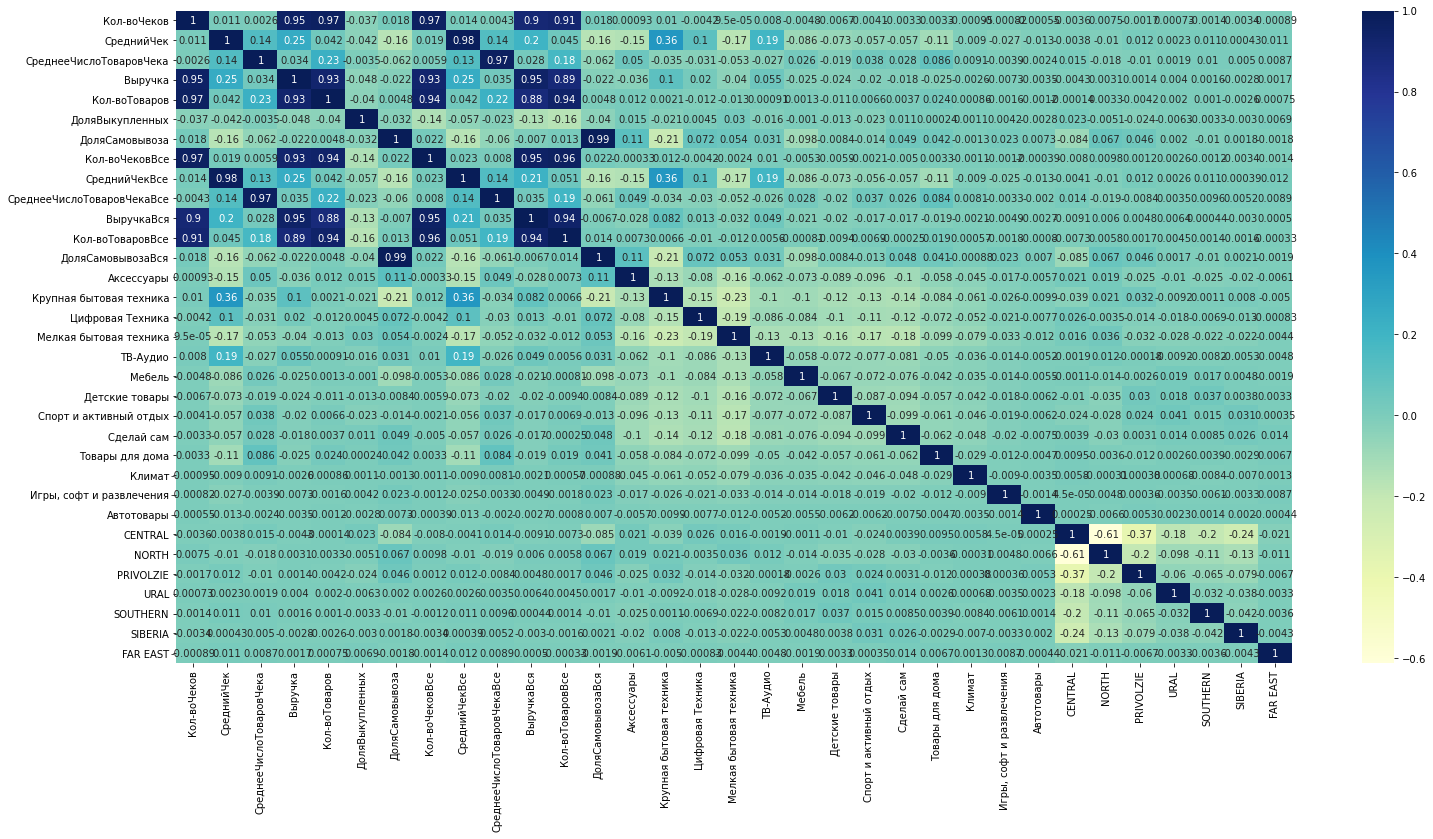

In [32]:
plt.style.context('seaborn');
fig = plt.figure(figsize = (25, 12))
sns.heatmap(vitr_df.corr(), annot=True, cmap = 'YlGnBu');

In [33]:
corr = vitr_df.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Кол-воЧеков,СреднийЧек,СреднееЧислоТоваровЧека,Выручка,Кол-воТоваров,ДоляВыкупленных,ДоляСамовывоза,Кол-воЧековВсе,СреднийЧекВсе,СреднееЧислоТоваровЧекаВсе,ВыручкаВся,Кол-воТоваровВсе,ДоляСамовывозаВся,Аксессуары,Крупная бытовая техника,Цифровая Техника,Мелкая бытовая техника,ТВ-Аудио,Мебель,Детские товары,Спорт и активный отдых,Сделай сам,Товары для дома,Климат,"Игры, софт и развлечения",Автотовары,CENTRAL,NORTH,PRIVOLZIE,URAL,SOUTHERN,SIBERIA,FAR EAST
Кол-воЧеков,1.00,0.03,0.15,0.21,0.64,-0.17,0.05,0.65,0.04,0.17,0.21,0.53,0.05,0.10,0.07,0.04,0.03,0.08,0.03,0.02,0.05,0.06,0.10,0.04,0.02,0.00,-0.01,0.02,0.00,-0.01,-0.00,-0.01,-0.01
СреднийЧек,0.03,1.00,0.09,0.98,0.09,-0.05,-0.26,0.05,0.99,0.09,0.94,0.09,-0.26,-0.23,0.42,0.17,-0.16,0.18,-0.08,-0.04,-0.06,-0.01,-0.16,0.02,-0.05,-0.02,-0.01,-0.02,0.02,0.00,0.02,0.01,0.01
СреднееЧислоТоваровЧека,0.15,0.09,1.00,0.11,0.82,-0.06,-0.08,0.12,0.08,0.97,0.11,0.65,-0.08,0.17,-0.01,0.01,-0.04,0.01,0.06,-0.01,0.06,0.06,0.16,0.04,0.00,0.00,0.03,-0.02,-0.01,0.00,0.01,-0.01,0.01
Выручка,0.21,0.98,0.11,1.00,0.20,-0.08,-0.24,0.16,0.97,0.12,0.97,0.18,-0.24,-0.20,0.42,0.17,-0.15,0.19,-0.07,-0.04,-0.05,0.00,-0.14,0.03,-0.05,-0.02,-0.01,-0.01,0.02,0.00,0.02,0.00,0.01
Кол-воТоваров,0.64,0.09,0.82,0.20,1.00,-0.13,-0.03,0.44,0.09,0.81,0.20,0.80,-0.03,0.18,0.04,0.03,-0.02,0.05,0.06,-0.00,0.06,0.07,0.17,0.05,0.01,0.00,0.02,-0.01,-0.01,-0.00,0.01,-0.01,0.00
ДоляВыкупленных,-0.17,-0.05,-0.06,-0.08,-0.13,1.00,-0.03,-0.82,-0.08,-0.11,-0.28,-0.64,-0.02,-0.01,-0.04,-0.01,0.01,-0.04,-0.01,-0.02,-0.03,-0.01,-0.03,-0.02,0.00,-0.00,0.02,-0.01,-0.02,-0.00,-0.00,-0.00,0.01
ДоляСамовывоза,0.05,-0.26,-0.08,-0.24,-0.03,-0.03,1.00,0.05,-0.25,-0.07,-0.23,-0.01,0.99,0.10,-0.21,0.07,0.05,0.03,-0.10,-0.01,-0.01,0.05,0.03,0.00,0.02,0.01,-0.08,0.07,0.05,0.00,-0.01,0.00,-0.00
Кол-воЧековВсе,0.65,0.05,0.12,0.16,0.44,-0.82,0.05,1.00,0.07,0.17,0.32,0.79,0.04,0.06,0.06,0.02,-0.00,0.06,0.02,0.03,0.05,0.03,0.06,0.03,0.01,0.00,-0.02,0.02,0.02,0.00,0.00,-0.00,-0.01
СреднийЧекВсе,0.04,0.99,0.08,0.97,0.09,-0.08,-0.25,0.07,1.00,0.09,0.96,0.11,-0.26,-0.22,0.42,0.17,-0.16,0.18,-0.08,-0.04,-0.06,-0.01,-0.16,0.02,-0.05,-0.02,-0.01,-0.02,0.02,0.00,0.02,0.01,0.01
СреднееЧислоТоваровЧекаВсе,0.17,0.09,0.97,0.12,0.81,-0.11,-0.07,0.17,0.09,1.00,0.13,0.68,-0.07,0.17,-0.00,0.01,-0.04,0.02,0.06,-0.01,0.06,0.06,0.16,0.04,0.00,0.00,0.03,-0.02,-0.01,0.00,0.01,-0.00,0.01


Удаление лишних корреляций и последующая проверка

In [34]:
df = vitr_df.drop(['Выручка', 'ВыручкаВся', 'СреднийЧекВсе', 'СреднееЧислоТоваровЧекаВсе', 'ДоляСамовывозаВся'],
             axis=1)

In [35]:
corr = df.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Кол-воЧеков,СреднийЧек,СреднееЧислоТоваровЧека,Кол-воТоваров,ДоляВыкупленных,ДоляСамовывоза,Кол-воЧековВсе,Кол-воТоваровВсе,Аксессуары,Крупная бытовая техника,Цифровая Техника,Мелкая бытовая техника,ТВ-Аудио,Мебель,Детские товары,Спорт и активный отдых,Сделай сам,Товары для дома,Климат,"Игры, софт и развлечения",Автотовары,CENTRAL,NORTH,PRIVOLZIE,URAL,SOUTHERN,SIBERIA,FAR EAST
Кол-воЧеков,1.00,0.03,0.15,0.64,-0.17,0.05,0.65,0.53,0.10,0.07,0.04,0.03,0.08,0.03,0.02,0.05,0.06,0.10,0.04,0.02,0.00,-0.01,0.02,0.00,-0.01,-0.00,-0.01,-0.01
СреднийЧек,0.03,1.00,0.09,0.09,-0.05,-0.26,0.05,0.09,-0.23,0.42,0.17,-0.16,0.18,-0.08,-0.04,-0.06,-0.01,-0.16,0.02,-0.05,-0.02,-0.01,-0.02,0.02,0.00,0.02,0.01,0.01
СреднееЧислоТоваровЧека,0.15,0.09,1.00,0.82,-0.06,-0.08,0.12,0.65,0.17,-0.01,0.01,-0.04,0.01,0.06,-0.01,0.06,0.06,0.16,0.04,0.00,0.00,0.03,-0.02,-0.01,0.00,0.01,-0.01,0.01
Кол-воТоваров,0.64,0.09,0.82,1.00,-0.13,-0.03,0.44,0.80,0.18,0.04,0.03,-0.02,0.05,0.06,-0.00,0.06,0.07,0.17,0.05,0.01,0.00,0.02,-0.01,-0.01,-0.00,0.01,-0.01,0.00
ДоляВыкупленных,-0.17,-0.05,-0.06,-0.13,1.00,-0.03,-0.82,-0.64,-0.01,-0.04,-0.01,0.01,-0.04,-0.01,-0.02,-0.03,-0.01,-0.03,-0.02,0.00,-0.00,0.02,-0.01,-0.02,-0.00,-0.00,-0.00,0.01
ДоляСамовывоза,0.05,-0.26,-0.08,-0.03,-0.03,1.00,0.05,-0.01,0.10,-0.21,0.07,0.05,0.03,-0.10,-0.01,-0.01,0.05,0.03,0.00,0.02,0.01,-0.08,0.07,0.05,0.00,-0.01,0.00,-0.00
Кол-воЧековВсе,0.65,0.05,0.12,0.44,-0.82,0.05,1.00,0.79,0.06,0.06,0.02,-0.00,0.06,0.02,0.03,0.05,0.03,0.06,0.03,0.01,0.00,-0.02,0.02,0.02,0.00,0.00,-0.00,-0.01
Кол-воТоваровВсе,0.53,0.09,0.65,0.80,-0.64,-0.01,0.79,1.00,0.14,0.04,0.02,-0.03,0.05,0.05,0.01,0.06,0.06,0.13,0.04,0.00,0.01,0.00,-0.00,0.00,0.00,0.00,-0.01,-0.00
Аксессуары,0.10,-0.23,0.17,0.18,-0.01,0.10,0.06,0.14,1.00,-0.11,-0.01,-0.14,-0.02,-0.07,-0.09,-0.09,-0.09,-0.03,-0.04,-0.01,-0.00,0.03,0.02,-0.03,-0.01,-0.03,-0.02,-0.01
Крупная бытовая техника,0.07,0.42,-0.01,0.04,-0.04,-0.21,0.06,0.04,-0.11,1.00,-0.15,-0.21,-0.08,-0.10,-0.12,-0.13,-0.13,-0.06,-0.04,-0.02,-0.01,-0.04,0.02,0.03,-0.01,0.00,0.01,-0.01


Удаление выбросов

In [36]:
%%time
outliers = IsolationForest(n_estimators=20, random_state=42).fit_predict(df.values)  # fit 3 trees  
outliers = (outliers+1)//2

print('% of outliers with Isolation forest:', 1 - (np.sum(outliers) / df.shape[0]))

% of outliers with Isolation forest: 0.053309049465345204
CPU times: total: 953 ms
Wall time: 959 ms


In [37]:
df = df.loc[np.array(df.index)[outliers == 1]]
df

,Кол-воЧеков,СреднийЧек,СреднееЧислоТоваровЧека,Кол-воТоваров,ДоляВыкупленных,ДоляСамовывоза,Кол-воЧековВсе,Кол-воТоваровВсе,Аксессуары,Крупная бытовая техника,...,Климат,"Игры, софт и развлечения",Автотовары,CENTRAL,NORTH,PRIVOLZIE,URAL,SOUTHERN,SIBERIA,FAR EAST
Phone_new,,,,,,,,,,,,,,,,,,,,,
55574950-51575552495774,1.0,429990.0,1.0,1.0,1.000000,0.0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
55575453-51505053495370,1.0,369990.0,1.0,1.0,1.000000,0.0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
55574953-51485057535575,1.0,259990.0,1.0,1.0,1.000000,1.0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
55574857-54575452545473,1.0,256430.0,1.0,1.0,1.000000,0.0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
55575451-54575253575277,1.0,249990.0,1.0,1.0,1.000000,0.0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55574848-505354565550715,1.0,2.0,1.0,1.0,1.000000,1.0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
55575048-50505757545376,1.0,2.0,2.0,2.0,0.666667,0.0,2,3.0,0.5,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
55574955-53544849485370,1.0,1.0,1.0,1.0,0.333333,1.0,2,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Нормализация

In [38]:
scaler = preprocessing.StandardScaler()
#scaler = preprocessing.MinMaxScaler()
X = scaler.fit_transform(df)
X

array([[-2.23138958e-01,  4.23916246e+01, -2.75754224e-01, ...,
        -1.84392213e-01, -2.13178354e-01, -1.91316295e-02],
       [-2.23138958e-01,  3.63584583e+01, -2.75754224e-01, ...,
        -1.84392213e-01, -2.13178354e-01, -1.91316295e-02],
       [-2.23138958e-01,  2.52976535e+01, -2.75754224e-01, ...,
        -1.84392213e-01, -2.13178354e-01, -1.91316295e-02],
       ...,
       [-2.23138958e-01, -8.44961089e-01, -2.75754224e-01, ...,
        -1.84392213e-01,  4.69090778e+00, -1.91316295e-02],
       [-2.23138958e-01, -8.44961089e-01, -2.75754224e-01, ...,
        -1.84392213e-01, -2.13178354e-01, -1.91316295e-02],
       [-2.23138958e-01, -8.44961089e-01, -2.75754224e-01, ...,
        -1.84392213e-01, -2.13178354e-01, -1.91316295e-02]])

In [39]:
X.shape

(84726, 28)

Выбор оптимального числа кластеров методом локтя

In [40]:
from scipy.spatial.distance import cdist

In [41]:
%%time
# k means determine k
distortions = []
K = range(2,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k, max_iter=1000, n_init=40, random_state=42).fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    
    print('{} / {}'.format(k,K[-1]))

2 / 19
3 / 19
4 / 19
5 / 19
6 / 19
7 / 19
8 / 19
9 / 19
10 / 19
11 / 19
12 / 19
13 / 19
14 / 19
15 / 19
16 / 19
17 / 19
18 / 19
19 / 19
CPU times: total: 12min 3s
Wall time: 1min 50s


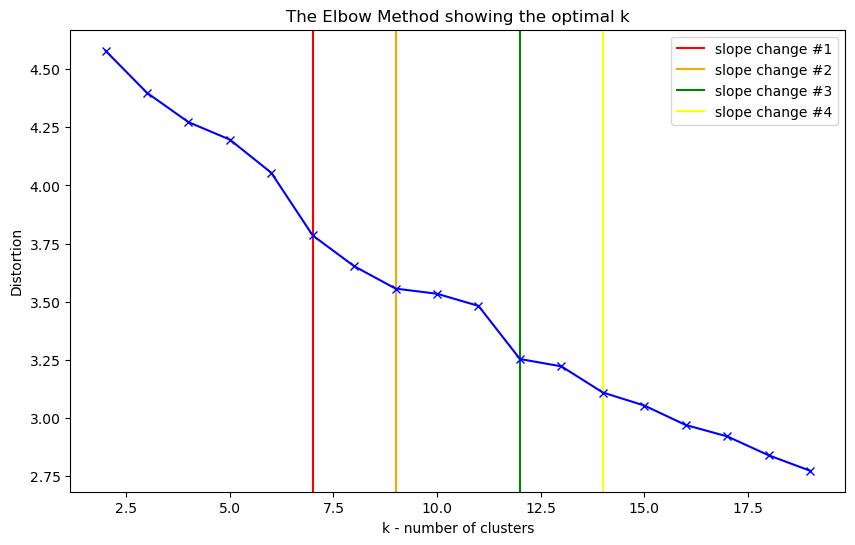

In [42]:
# Plot the elbow
plt.figure(figsize=(10, 6))
plt.axvline(7, 0, 1, label='slope change #1', color='red')
plt.axvline(9, 0, 1, label='slope change #2', color='orange')
plt.axvline(12, 0, 1, label='slope change #3', color='green')
plt.axvline(14, 0, 1, label='slope change #4', color='yellow')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k - number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
#plt.step(0,1)
plt.legend(); plt.show()

Определение главных компонент

In [43]:
from sklearn.decomposition import PCA, TruncatedSVD

In [44]:
X.shape

(84726, 28)

In [78]:
Y_pca = PCA(n_components=11).fit_transform(X);
Y_svd = TruncatedSVD(n_components=11).fit_transform(X);

In [79]:
K = 8
kmeanModel = KMeans(n_clusters=K, max_iter=3000, n_init=100, random_state=22).fit(X)
#kmeanModel = KMeans(n_clusters=K).fit(X) # BEST

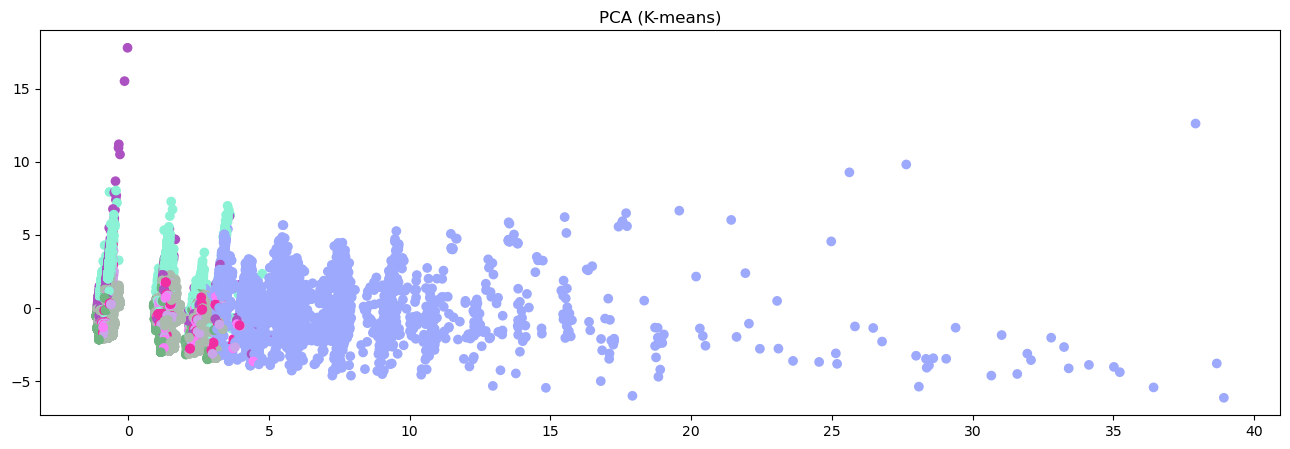

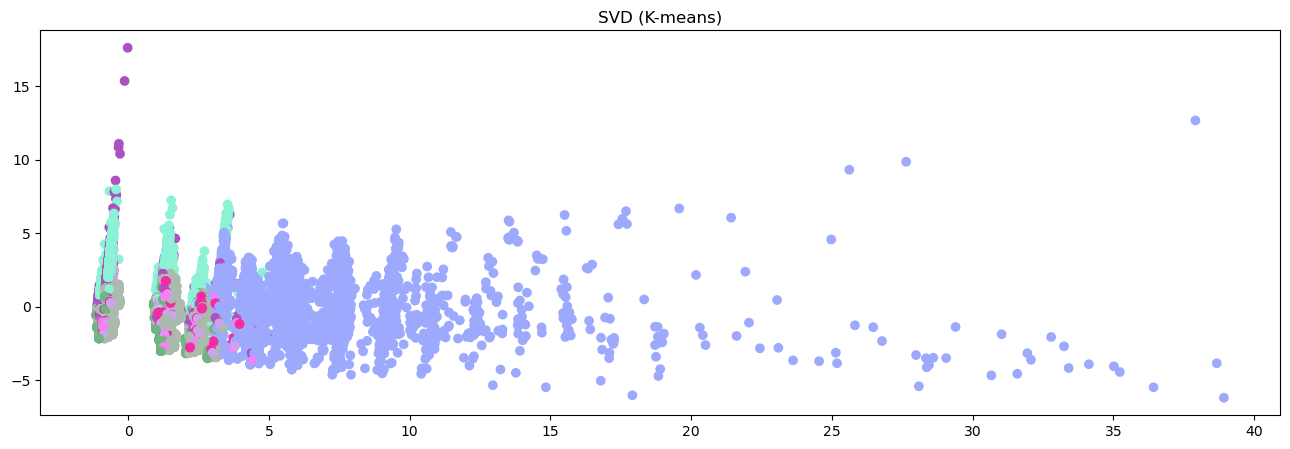

In [80]:
np.random.seed(221)
colors = np.sqrt(np.random.randint(0,255, size=(K, 3))/255)
c_arr = np.array(list(map(lambda x: colors[x], list(kmeanModel.labels_))))

plt.figure(figsize=(16,5));
plt.title('PCA (K-means)')
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=c_arr);

plt.figure(figsize=(16,5)); plt.title('SVD (K-means)')
plt.scatter(Y_svd[:, 0], Y_svd[:, 1], c=c_arr);

Разбиение на 7 - 14 кластеров

In [81]:
# coordinates of cluster center
centroids = kmeanModel.cluster_centers_ 

# cluster label for each data point
labels = kmeanModel.labels_

df['Labels'] = kmeanModel.labels_

df_1 = vitr_df.loc[df[df['Labels'] == 0].index]
df_2 = vitr_df.loc[df[df['Labels'] == 1].index]
df_3 = vitr_df.loc[df[df['Labels'] == 2].index]
df_4 = vitr_df.loc[df[df['Labels'] == 3].index]
df_5 = vitr_df.loc[df[df['Labels'] == 4].index]
df_6 = vitr_df.loc[df[df['Labels'] == 5].index]
df_7 = vitr_df.loc[df[df['Labels'] == 6].index]
df_8 = vitr_df.loc[df[df['Labels'] == 7].index]
#df_9 = vitr_df.loc[df[df['Labels'] == 8].index]
#df_10 = vitr_df.loc[df[df['Labels'] == 9].index]
#df_11 = vitr_df.loc[df[df['Labels'] == 10].index]
#df_12 = vitr_df.loc[df[df['Labels'] == 11].index]
#df_13 = vitr_df.loc[df[df['Labels'] == 12].index]
#df_14 = vitr_df.loc[df[df['Labels'] == 13].index]
tot_df = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8]
print('Segment 1: ', len(df_1)*100/len(df))
print('Segment 2: ', len(df_2)*100/len(df))
print('Segment 3: ', len(df_3)*100/len(df))
print('Segment 4: ', len(df_4)*100/len(df))
print('Segment 5: ', len(df_5)*100/len(df))
print('Segment 6: ', len(df_6)*100/len(df))
print('Segment 7: ', len(df_7)*100/len(df))
print('Segment 8: ', len(df_8)*100/len(df))
#print('Segment 9: ', len(df_9)*100/len(df))
#print('Segment 10: ', len(df_10)*100/len(df))
#print('Segment 11: ', len(df_11)*100/len(df))
#print('Segment 12: ', len(df_12)*100/len(df))
#print('Segment 13: ', len(df_13)*100/len(df))
#print('Segment 14: ', len(df_14)*100/len(df))
print('df: ', len(df))
#35% - не больше (до 14 кластеров)

Segment 1:  14.82779784245686
Segment 2:  28.544956683898686
Segment 3:  7.5018294266222885
Segment 4:  7.472322545617638
Segment 5:  5.4422491324976985
Segment 6:  9.111724854236007
Segment 7:  5.3466468380426315
Segment 8:  21.75247267662819
Segment 9:  0.0
df:  84726


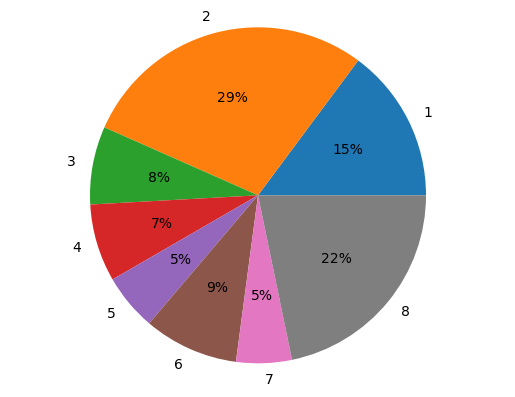

In [83]:
labels = '1', '2', '3', '4', '5', '6', '7', '8'
sizes = [len(df_1)*100/len(df), len(df_2)*100/len(df), len(df_3)*100/len(df), len(df_4)*100/len(df), len(df_5)*100/len(df), len(df_6)*100/len(df), len(df_7)*100/len(df), len(df_8)*100/len(df)]

fig1, ax1 = plt.subplots()
explode = (0, 0, 0, 0, 0, 0, 0, 0)
ax1.pie(sizes, labels=labels,explode =explode, autopct='%1.f%%')
ax1.axis('equal')  
plt.show()

Вывод таблиц показателей по кластерам

In [84]:
#Количество успешных заказов
cluster_gqbil = [tot_df[i]['Кол-воЧеков'].sum()/len(tot_df[i]) for i in range(len(tot_df))]
#Количество выкупленных товаров на чек 
cluster_gmqbil = [tot_df[i]['Кол-воТоваров'].sum()/ tot_df[i]['Кол-воЧеков'].sum() for i in range(len(tot_df))]
#Количество выкупленных товаров на чек на клиента
cluster_gumqbil = [(tot_df[i]['Кол-воТоваров']/ tot_df[i]['Кол-воЧеков']).sum()/len(tot_df[i]) for i in range(len(tot_df))]
#Количество всех товаров на чек
cluster_mqbil = [tot_df[i]['Кол-воТоваровВсе'].sum()/ tot_df[i]['Кол-воЧековВсе'].sum() for i in range(len(tot_df))]
#Количество всех товаров на чек на клиента
cluster_umqbil = [(tot_df[i]['Кол-воТоваровВсе']/ tot_df[i]['Кол-воЧековВсе']).sum()/len(tot_df[i]) for i in range(len(tot_df))]
#Цена выкупленного товара
cluster_gprice = [tot_df[i]['Выручка'].sum()/tot_df[i]['Кол-воТоваров'].sum() for i in range(len(tot_df))]
#Цена выкупленного товара на клиента
cluster_guprice = [(tot_df[i]['Выручка']/tot_df[i]['Кол-воТоваров']).sum()/len(tot_df[i]) for i in range(len(tot_df))]
#Цена всех товаров
cluster_price = [tot_df[i]['ВыручкаВся'].sum()/tot_df[i]['Кол-воТоваровВсе'].sum() for i in range(len(tot_df))]
#Цена всех товаров на клиента
cluster_uprice = [(tot_df[i]['ВыручкаВся']/tot_df[i]['Кол-воТоваровВсе']).sum()/len(tot_df[i]) for i in range(len(tot_df))]
#Средний чек
cluster_gwin = [tot_df[i]['Выручка'].sum()/len(tot_df[i]) for i in range(len(tot_df))]
#Средний чек ожидаемый
cluster_win = [tot_df[i]['ВыручкаВся'].sum()/len(tot_df[i]) for i in range(len(tot_df))]
#Доля самовывоза
cluster_gdeliv = [tot_df[i]['ДоляСамовывоза'].sum()/len(tot_df[i])*100 for i in range(len(tot_df))]
#Доля самовывоза вся
cluster_deliv = [tot_df[i]['ДоляСамовывозаВся'].sum()/len(tot_df[i])*100 for i in range(len(tot_df))]
#Доли категорий
cluster_cat = [[tot_df[i][new_df['TN'].unique()[j]].sum()/len(tot_df[i])*100 for i in range(len(tot_df))] for j in range(len(new_df['TN'].unique()))]


C:\Users\spave\AppData\Local\Temp\ipykernel_20180\215793415.py:2: RuntimeWarning: invalid value encountered in double_scalars
  cluster_gqbil = [tot_df[i]['Кол-воЧеков'].sum()/len(tot_df[i]) for i in range(len(tot_df))]
C:\Users\spave\AppData\Local\Temp\ipykernel_20180\215793415.py:4: RuntimeWarning: invalid value encountered in double_scalars
  cluster_gmqbil = [tot_df[i]['Кол-воТоваров'].sum()/ tot_df[i]['Кол-воЧеков'].sum() for i in range(len(tot_df))]
C:\Users\spave\AppData\Local\Temp\ipykernel_20180\215793415.py:6: RuntimeWarning: invalid value encountered in double_scalars
  cluster_gumqbil = [(tot_df[i]['Кол-воТоваров']/ tot_df[i]['Кол-воЧеков']).sum()/len(tot_df[i]) for i in range(len(tot_df))]
C:\Users\spave\AppData\Local\Temp\ipykernel_20180\215793415.py:8: RuntimeWarning: invalid value encountered in double_scalars
  cluster_mqbil = [tot_df[i]['Кол-воТоваровВсе'].sum()/ tot_df[i]['Кол-воЧековВсе'].sum() for i in range(len(tot_df))]
C:\Users\spave\AppData\Local\Temp\ipykernel

In [85]:
with ExcelWriter("VKR.xlsx", engine="openpyxl", mode = "a") as writer:
    pd.DataFrame({'УспешныеЗаказы': cluster_gqbil, 'ВыкупленныхТоваровНаЧек': cluster_gmqbil, 'ВыкупленныхТоваровНаЧекКлиента': cluster_gumqbil, 'ВсехТоваровНаЧек': cluster_mqbil, 'ВсехТоваровНаЧекКлиента': cluster_umqbil, 'ЦенаВыкупленногоТовара': cluster_gprice, 'ЦенаВыкупленногоТовараКлиента': cluster_guprice, 'ЦенаВсехТоваров': cluster_price, 'ЦенаВсехТоваровКлиента': cluster_uprice, 'СреднийЧек': cluster_gwin, 'СреднийЧекОжидаемый': cluster_win, 'ДоляСамовывоза': cluster_gdeliv, 'ДоляСамовывозаВся': cluster_deliv, new_df['TN'].unique()[0]: cluster_cat[0], new_df['TN'].unique()[1]: cluster_cat[1], new_df['TN'].unique()[2]: cluster_cat[2], new_df['TN'].unique()[3]: cluster_cat[3], new_df['TN'].unique()[4]: cluster_cat[4], new_df['TN'].unique()[5]: cluster_cat[5], new_df['TN'].unique()[6]: cluster_cat[6], new_df['TN'].unique()[7]: cluster_cat[7], new_df['TN'].unique()[8]: cluster_cat[8], new_df['TN'].unique()[9]: cluster_cat[9], new_df['TN'].unique()[10]: cluster_cat[10], new_df['TN'].unique()[11]: cluster_cat[11], new_df['TN'].unique()[12]: cluster_cat[12]}).to_excel(writer,sheet_name="Clusters")

Проверка качества кластеризации

In [86]:
#Проверка качества модели
results_db_kmeans = {}
for i in range(2, 13):
    
    kmeans = KMeans(n_clusters = i)
    labels = kmeans.fit_predict(X)
    
    db_index = davies_bouldin_score(X, labels)
    results_db_kmeans.update({i: db_index})

C:\Users\spave\AppData\Local\Temp\ipykernel_20180\4229351539.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


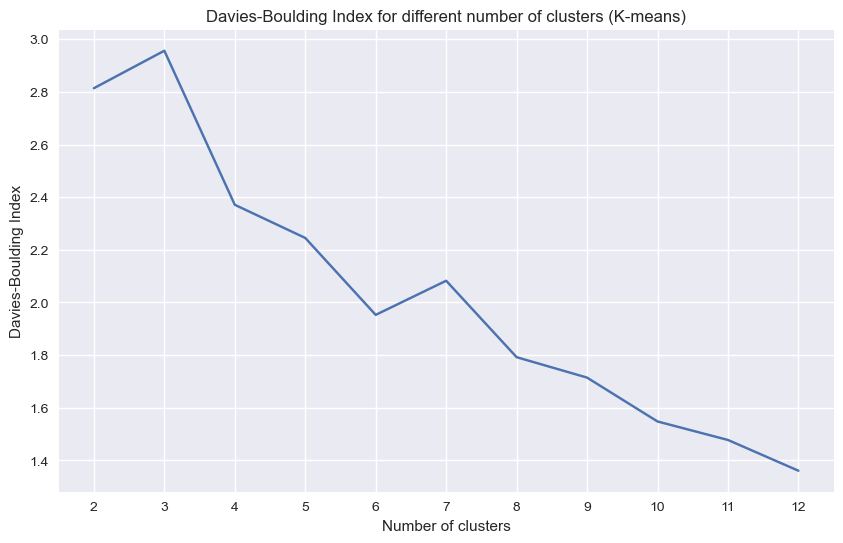

In [87]:
plt.style.use('seaborn')
plt.figure(figsize=(10, 6))

plt.plot(list(results_db_kmeans.keys()), list(results_db_kmeans.values()))

plt.xticks(np.arange(2, 13, step = 1))
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Boulding Index')
plt.title('Davies-Boulding Index for different number of clusters (K-means)')
plt.show()

In [91]:
results_sil_kmeans = {}
for i in range(2, 13):
    
    kmeans = KMeans(n_clusters = i)
    labels = kmeans.fit_predict(X)
    
    sil_score = silhouette_score(X, labels)
    results_sil_kmeans.update({i: sil_score})

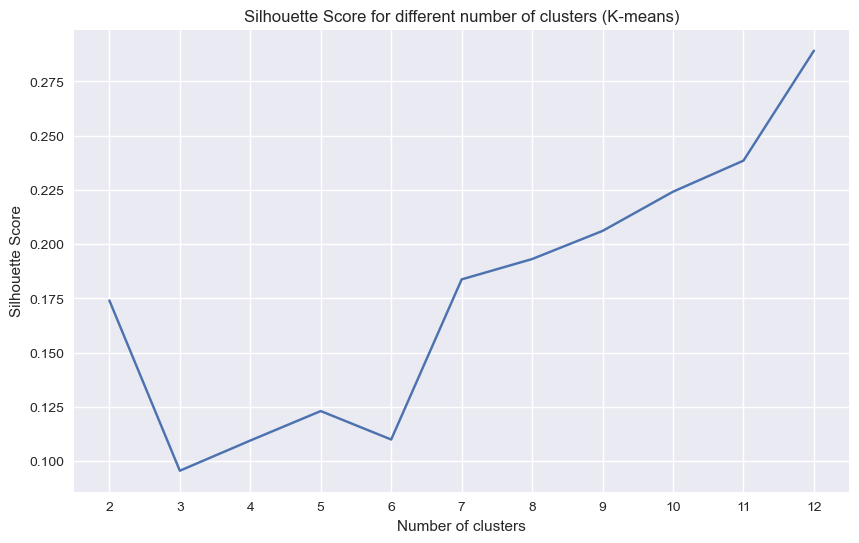

In [92]:
plt.figure(figsize=(10, 6))

plt.plot(list(results_sil_kmeans.keys()), list(results_sil_kmeans.values()), label = 'Silhouette Score')

plt.xticks(np.arange(2, 13, step = 1))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different number of clusters (K-means)')
plt.show()

In [89]:
results_ch_kmeans = {}
for i in range(2, 13):
    
    kmeans = KMeans(n_clusters = i)
    labels = kmeans.fit_predict(X)
    
    ch_score = calinski_harabasz_score(X, labels)
    results_ch_kmeans.update({i: ch_score})

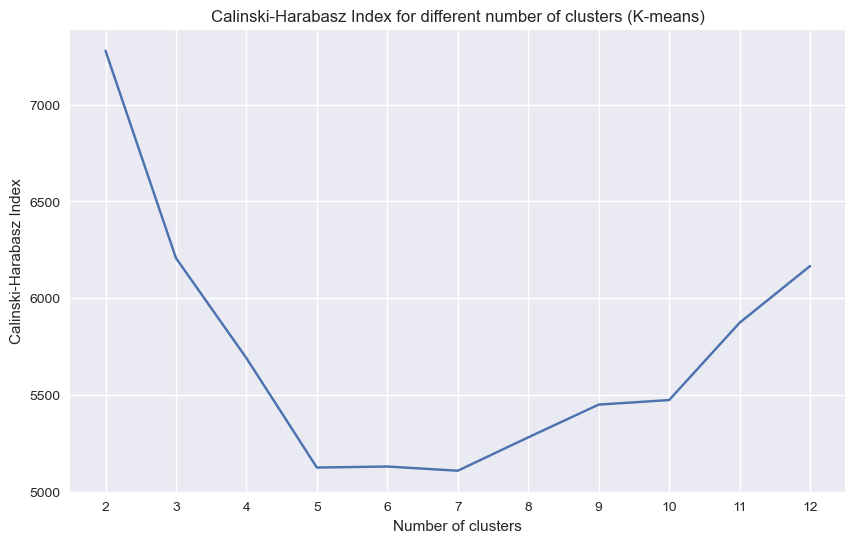

In [90]:
plt.figure(figsize=(10, 6))

plt.plot(list(results_ch_kmeans.keys()), list(results_ch_kmeans.values()), label = 'Calinski-Harabasz Index')

plt.xticks(np.arange(2, 13, step = 1))
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index for different number of clusters (K-means)')
plt.show()

Создание таблиц для MBA

In [93]:
#Индексы кластеров
mba_tit1 = pd.read_excel("mba.xlsx", sheet_name=0).set_index('Phone_new')
mba_tit2 = pd.read_excel("mba.xlsx", sheet_name=1).set_index('Phone_new')
mba_tit3 = pd.read_excel("mba.xlsx", sheet_name=2).set_index('Phone_new')
mba_tit4 = pd.read_excel("mba.xlsx", sheet_name=3).set_index('Phone_new')
mba_tit5 = pd.read_excel("mba.xlsx", sheet_name=4).set_index('Phone_new')
mba_tit6 = pd.read_excel("mba.xlsx", sheet_name=5).set_index('Phone_new')
mba_tit7 = pd.read_excel("mba.xlsx", sheet_name=6).set_index('Phone_new')
mba_tit8 = pd.read_excel("mba.xlsx", sheet_name=7).set_index('Phone_new')

In [ ]:
#Создание таблиц MBA с более чем 1ой покупкой в чеке
MB_df1 = new_df[new_df['Order_ID'].isin(new_df.groupby(['Phone_new', 'Order_ID'])['Order_ID'].count()[mba_tit1.index][new_df.groupby(['Phone_new', 'Order_ID'])['Order_ID'].count() > 1].index.get_level_values(1))].groupby(['Phone_new', 'TK'])['Quant'].sum().unstack().dropna(thresh=2).fillna(0) > 0
MB_df2 = new_df[new_df['Order_ID'].isin(new_df.groupby(['Phone_new', 'Order_ID'])['Order_ID'].count()[mba_tit2.index][new_df.groupby(['Phone_new', 'Order_ID'])['Order_ID'].count() > 1].index.get_level_values(1))].groupby(['Phone_new', 'TK'])['Quant'].sum().unstack().dropna(thresh=2).fillna(0) > 0
MB_df3 = new_df[new_df['Order_ID'].isin(new_df.groupby(['Phone_new', 'Order_ID'])['Order_ID'].count()[mba_tit3.index][new_df.groupby(['Phone_new', 'Order_ID'])['Order_ID'].count() > 1].index.get_level_values(1))].groupby(['Phone_new', 'TK'])['Quant'].sum().unstack().dropna(thresh=2).fillna(0) > 0
MB_df4 = new_df[new_df['Order_ID'].isin(new_df.groupby(['Phone_new', 'Order_ID'])['Order_ID'].count()[mba_tit4.index][new_df.groupby(['Phone_new', 'Order_ID'])['Order_ID'].count() > 1].index.get_level_values(1))].groupby(['Phone_new', 'TK'])['Quant'].sum().unstack().dropna(thresh=2).fillna(0) > 0
MB_df5 = new_df[new_df['Order_ID'].isin(new_df.groupby(['Phone_new', 'Order_ID'])['Order_ID'].count()[mba_tit5.index][new_df.groupby(['Phone_new', 'Order_ID'])['Order_ID'].count() > 1].index.get_level_values(1))].groupby(['Phone_new', 'TK'])['Quant'].sum().unstack().dropna(thresh=2).fillna(0) > 0
MB_df6 = new_df[new_df['Order_ID'].isin(new_df.groupby(['Phone_new', 'Order_ID'])['Order_ID'].count()[mba_tit6.index][new_df.groupby(['Phone_new', 'Order_ID'])['Order_ID'].count() > 1].index.get_level_values(1))].groupby(['Phone_new', 'TK'])['Quant'].sum().unstack().dropna(thresh=2).fillna(0) > 0
MB_df7 = new_df[new_df['Order_ID'].isin(new_df.groupby(['Phone_new', 'Order_ID'])['Order_ID'].count()[mba_tit7.index][new_df.groupby(['Phone_new', 'Order_ID'])['Order_ID'].count() > 1].index.get_level_values(1))].groupby(['Phone_new', 'TK'])['Quant'].sum().unstack().dropna(thresh=2).fillna(0) > 0
MB_df8 = new_df[new_df['Order_ID'].isin(new_df.groupby(['Phone_new', 'Order_ID'])['Order_ID'].count()[mba_tit8.index][new_df.groupby(['Phone_new', 'Order_ID'])['Order_ID'].count() > 1].index.get_level_values(1))].groupby(['Phone_new', 'TK'])['Quant'].sum().unstack().dropna(thresh=2).fillna(0) > 0

In [122]:
with ExcelWriter("mba.xlsx", engine="openpyxl", mode = "w") as writer:
    MB_df1.to_excel(writer,sheet_name="MBA1")
with ExcelWriter("mba.xlsx", engine="openpyxl", mode = "a") as writer:
    MB_df2.to_excel(writer,sheet_name="MBA2")
    MB_df3.to_excel(writer,sheet_name="MBA3")
    MB_df4.to_excel(writer,sheet_name="MBA4")
    MB_df5.to_excel(writer,sheet_name="MBA5")
    MB_df6.to_excel(writer,sheet_name="MBA6")
    MB_df7.to_excel(writer,sheet_name="MBA7")
    MB_df8.to_excel(writer,sheet_name="MBA8")


Создание таблиц для SVD

In [95]:
#ratings = new_df.groupby(['Phone_new', 'TK'])['Quant'].sum().unstack().fillna(0)
ratings = [new_df[new_df['Phone_new'].isin(tot_df[i].index)].groupby(['Phone_new', 'TK'])['Quant'].sum().reset_index() for i in range(len(tot_df))]


In [96]:
with ExcelWriter("ratings.xlsx", engine="openpyxl", mode = "w") as writer:
    ratings[0].to_excel(writer,sheet_name="Rt1")
with ExcelWriter("ratings.xlsx", engine="openpyxl", mode = "a") as writer:
    ratings[1].to_excel(writer,sheet_name="Rt2")
    ratings[2].to_excel(writer,sheet_name="Rt3")
    ratings[3].to_excel(writer,sheet_name="Rt4")
    ratings[4].to_excel(writer,sheet_name="Rt5")
    ratings[5].to_excel(writer,sheet_name="Rt6")
    ratings[6].to_excel(writer,sheet_name="Rt7")
    ratings[7].to_excel(writer,sheet_name="Rt8")


Создание таблиц для NCF

In [97]:
#NCF

In [98]:
NCF_df = [new_df[new_df['Phone_new'].isin(tot_df[i].index)].groupby(['Phone_new', 'TK', 'ChangeDate'])['Quant'].sum().reset_index().rename(columns={'Phone_new': 'userID', 'TK': 'itemID', 'Quant': 'rating', 'ChangeDate': 'timestamp' }) for i in range(len(tot_df))]

In [99]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
data_new1 = [labelencoder.fit_transform(NCF_df[i]['userID']) for i in range(len(tot_df))]
data_new2 = [labelencoder.fit_transform(NCF_df[i]['itemID']) for i in range(len(tot_df))]
data_new3 = [labelencoder.fit_transform(NCF_df[i]['timestamp']) for i in range(len(tot_df))]
data_new2

[array([27, 27, 38, ..., 11, 27, 11]),
 array([36, 63,  9, ..., 56, 63, 82]),
 array([ 6, 37,  4, ..., 35, 39, 35]),
 array([23,  7,  7, ..., 37, 23, 23]),
 array([82, 84,  8, ..., 38, 56, 87]),
 array([19, 50, 37, ..., 19, 19, 19]),
 array([ 6, 14, 46, ...,  6, 46, 14]),
 array([ 8,  8, 13, ..., 15, 11,  8]),
 array([], dtype=float64)]

In [100]:
NCF_tab = [pd.concat([pd.DataFrame({'userID': data_new1[i], 'itemID': data_new2[i], 'timestamp': data_new2[i]}), NCF_df[i]['rating']], axis =1) for i in range(len(tot_df))]

In [101]:
with ExcelWriter("NCF.xlsx", engine="openpyxl", mode = "w") as writer:
    NCF_tab[0].to_excel(writer,sheet_name="NCF1")
with ExcelWriter("NCF.xlsx", engine="openpyxl", mode = "a") as writer:
    NCF_tab[1].to_excel(writer,sheet_name="NCF2")
    NCF_tab[2].to_excel(writer,sheet_name="NCF3")
    NCF_tab[3].to_excel(writer,sheet_name="NCF4")
    NCF_tab[4].to_excel(writer,sheet_name="NCF5")
    NCF_tab[5].to_excel(writer,sheet_name="NCF6")
    NCF_tab[6].to_excel(writer,sheet_name="NCF7")
    NCF_tab[7].to_excel(writer,sheet_name="NCF8")
